In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../')

In [2]:
df_neg_log_loss_90 = pd.read_csv('../metrics/metrics_neg_log_loss_0.9.csv')
df_neg_log_loss_60 = pd.read_csv('../metrics/metrics_neg_log_loss_0.6.csv')
df_neg_log_loss = pd.read_csv('../metrics/metrics_neg_log_loss_0.75.csv')

asset_type_map = {}

forex_assets = [
    "EURUSD", "USDJPY", "GBPUSD", "AUDUSD", "USDCHF",
    "USDCAD", "NZDUSD", "EURGBP", "EURJPY", "GBPJPY",
    "AUDJPY", "EURAUD", "CHFJPY", "EURCAD", "GBPCAD",
    "AUDCAD", "NZDJPY", "GBPCHF", "EURCHF", "USDSGD"
]
commodity_assets = ["XAUUSD", "XAGUSD"]
crypto_assets = ["X:BTCUSD", "X:ETHUSD", "X:LTCUSD", "X:XRPUSD"]
stocks_assets = [ "AAPL", "MSFT", "AMZN", "GOOGL"]

for a in forex_assets:
    asset_type_map[a] = "Forex"
for a in commodity_assets:
    asset_type_map[a] = "Commodities"
for a in crypto_assets:
    asset_type_map[a] = "Cryptocurrencies"
for a in stocks_assets:
    asset_type_map[a] = "Stocks"

# Apply type to your DataFrame
df_neg_log_loss["type"] = df_neg_log_loss["asset"].map(asset_type_map)
df_neg_log_loss_60["type"] = df_neg_log_loss_60["asset"].map(asset_type_map) 
df_neg_log_loss['fake_type'] = 'All Assets'
df_neg_log_loss_60['fake_type'] = 'All Assets'
df_neg_log_loss_90['fake_type'] = 'All Assets'
df_neg_log_loss_90['type'] = df_neg_log_loss_90['asset'].map(asset_type_map)

df_neg_log_loss['EPEL'] = df_neg_log_loss['Expected Profit'] / df_neg_log_loss['Expected Loss']
df_neg_log_loss_60['EPEL'] = df_neg_log_loss_60['Expected Profit'] / df_neg_log_loss_60['Expected Loss']
# df_neg_log_loss_90['EPEL'] = df_neg_log_loss_90['Expected Profit'] / df_neg_log_loss_90['Expected Loss']
df_neg_log_loss['EV'] = df_neg_log_loss['Expected Profit'] - df_neg_log_loss['Expected Loss']
df_neg_log_loss_60['EV'] = df_neg_log_loss_60['Expected Profit'] - df_neg_log_loss_60['Expected Loss']
# df_neg_log_loss_90['EV'] = df_neg_log_loss_90['Expected Profit'] - df_neg_log_loss_90['Expected Loss']


In [3]:

def pivot(df):

    # Assuming 'df_accuracy' is your original dataframe
    df_pivot = df.pivot_table(index=['model', 'asset', 'type', 'fake_type'], 
                                    columns='dataset', 
                                    values=[
                                        'Adjusted Expected Return', 'Expected Growth Rate', 'Negative Log Loss', 'Sharpe Ratio',
                                        'Accuracy', 'F1 Score', 'AUC', 'Sortino Ratio', 'Backtesting Final Value', 'Return over Risked Capital',
                                        'Backtesting Accuracy', 'EPEL', 'EV'
                                    ])

    # Flatten the MultiIndex columns
    df_pivot.columns = [f"{metric}_{dataset}" for metric, dataset in df_pivot.columns]

    # Reset index to make it a standard dataframe
    df_pivot.reset_index(inplace=True)

    # Now you can access a specific metric for test/val like:
    # df_pivot['Backtesting Accuracy_test']  # for test set
    # df_pivot['Backtesting Accuracy_val']   # for validation set
    return df_pivot


In [4]:
# df_accuracy = pivot(df_accuracy)
df_neg_log_loss = pivot(df_neg_log_loss)
# df_neg_log_loss_90 = pivot(df_neg_log_loss_90)
df_neg_log_loss_60 = pivot(df_neg_log_loss_60)

In [5]:
# First, isolate the metric columns (excluding the identifiers)
metric_columns = [col for col in df_neg_log_loss.columns if any(metric in col for metric in [
    'Adjusted Expected Return', 'Expected Growth Rate', 'Negative Log Loss', 'Sharpe Ratio',
    'Accuracy', 'F1 Score', 'AUC', 'Sortino Ratio', 'Backtesting Final Value', 'Return over Risked Capital',
    'Backtesting Accuracy', 'EPEL', 'EV'

])]

# Group by asset and rank each metric within the group
ranked_df = df_neg_log_loss.copy()
for col in metric_columns:
    ranked_df[f'{col}_rank'] = ranked_df.groupby('asset')[col].rank(ascending=False)

# Now 'ranked_df' has rank columns added per metric per asset
ranked_df.head()


model   asset    type   fake_type  AUC_test   AUC_val  Accuracy_test  \
0  ada_boost    AAPL  Stocks  All Assets  0.502120  0.504898       0.500286   
1  ada_boost    AMZN  Stocks  All Assets  0.500109  0.505790       0.504612   
2  ada_boost  AUDJPY   Forex  All Assets  0.526814  0.536982       0.517686   
3  ada_boost  AUDUSD   Forex  All Assets  0.536562  0.547438       0.536059   
4  ada_boost  CHFJPY   Forex  All Assets  0.460763  0.455758       0.508100   

   Accuracy_val  Adjusted Expected Return_test  Adjusted Expected Return_val  \
0      0.505931                       0.000040                      0.000121   
1      0.507477                       0.012746                      0.001882   
2      0.519572                       0.000004                      0.000001   
3      0.550759                       0.011488                      0.014693   
4      0.520448                       0.007399                      0.005780   

   ...  F1 Score_test_rank  F1 Score_val_rank  Negative Log Loss_test_rank  \
0  ...                 7.0                8.0                         12.0   
1  ...                 3.0                3.0                         12.0   
2  ...                 4.0                3.0                          1.0   
3  ...                 2.0                1.0                          1.0   
4  ...                 3.0                3.0                         12.0   

   Negative Log Loss_val_rank  Return over Risked Capital_test_rank  \
0                        12.0                                   7.0   
1                        12.0                                  11.0   
2                         3.0                                   3.0   
3                         1.0                                   7.0   
4                        10.0                                   9.0   

   Return over Risked Capital_val_rank  Sharpe Ratio_test_rank  \
0                                 12.0                     7.0   
1                                 12.0                    12.0   
2                                 10.0                     1.0   
3                                 10.0                     6.0   
4                                  9.0                    11.0   

   Sharpe Ratio_val_rank  Sortino Ratio_test_rank  Sortino Ratio_val_rank  
0                   12.0                      6.0                    10.0  
1                   12.0                     12.0                    12.0  
2                    7.0                      1.0                     8.0  
3                    5.0                      6.0                     5.0  
4                   12.0                     11.0                    12.0  

[5 rows x 56 columns]

In [64]:
ranked_df

model     asset              type   fake_type  AUC_test   AUC_val  \
0    ada_boost      AAPL            Stocks  All Assets  0.502120  0.504898   
1    ada_boost      AMZN            Stocks  All Assets  0.500109  0.505790   
2    ada_boost    AUDJPY             Forex  All Assets  0.526814  0.536982   
3    ada_boost    AUDUSD             Forex  All Assets  0.536562  0.547438   
4    ada_boost    CHFJPY             Forex  All Assets  0.460763  0.455758   
..         ...       ...               ...         ...       ...       ...   
295        sgd  X:ETHUSD  Cryptocurrencies  All Assets  0.508169  0.510480   
296        sgd  X:LTCUSD  Cryptocurrencies  All Assets  0.504422  0.509688   
297        sgd  X:XRPUSD  Cryptocurrencies  All Assets  0.491642  0.490689   
298        sgd    XAGUSD       Commodities  All Assets  0.555571  0.555872   
299        sgd    XAUUSD       Commodities  All Assets  0.532329  0.530937   

     Accuracy_test  Accuracy_val  Adjusted Expected Return_test  \
0         0.500286      0.505931                   3.992786e-05   
1         0.504612      0.507477                   1.274610e-02   
2         0.517686      0.519572                   3.776273e-06   
3         0.536059      0.550759                   1.148828e-02   
4         0.508100      0.520448                   7.398745e-03   
..             ...           ...                            ...   
295       0.505689      0.506991                   6.962145e-07   
296       0.502761      0.512272                   7.184105e-06   
297       0.503209      0.505171                   4.502340e-06   
298       0.542787      0.542072                   6.758095e-03   
299       0.521144      0.519952                   4.225117e-05   

     Adjusted Expected Return_val  ...  Negative Log Loss_test_rank  \
0                    1.208367e-04  ...                         12.0   
1                    1.882331e-03  ...                         12.0   
2                    1.465626e-06  ...                          1.0   
3                    1.469337e-02  ...                          1.0   
4                    5.780217e-03  ...                         12.0   
..                            ...  ...                          ...   
295                  3.847199e-07  ...                          4.0   
296                  0.000000e+00  ...                          6.0   
297                  0.000000e+00  ...                         11.0   
298                  6.771324e-03  ...                          9.0   
299                  3.112139e-05  ...                          9.0   

     Negative Log Loss_val_rank  Operations %_test_rank  \
0                          12.0                     6.0   
1                          12.0                     1.0   
2                           3.0                     6.0   
3                           1.0                     1.0   
4                          10.0                     6.0   
..                          ...                     ...   
295                         4.0                     5.0   
296                         7.0                     4.0   
297                        11.0                     3.0   
298                         9.0                     7.0   
299                         9.0                     9.0   

     Operations %_val_rank  Return over Risked Capital_test_rank  \
0                      7.0                                   7.0   
1                      1.0                                  11.0   
2                      6.0                                   3.0   
3                      1.0                                   7.0   
4                      6.0                                   9.0   
..                     ...                                   ...   
295                    6.0                                   1.0   
296                   10.0                                  11.0   
297                    6.5                                  11.0   
298                    7.

In [30]:
ranked_df.to_csv('ranked_df.csv', index=False)

In [6]:
def rank_then_mean(ranked_df):
    metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC',
               'Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital', 'EPEL', 'EV']
    
    # First rank for each asset, then get mean rank
    metrics = [col for col in ranked_df.columns if any(metric + '_test' in col for metric in metrics)]
    def process_asset_group(group):
        # Rank within the asset group (ascending=False means higher values get lower ranks)
        ranks = group[metrics].rank(ascending=False)
        return ranks
    
    # Group by asset, rank within each asset, then get mean rank
    result = ranked_df.groupby('asset').apply(process_asset_group)
    mean_ranks = result.groupby(level=0)[metrics].mean()
    
    return mean_ranks

def mean_then_rank(ranked_df):
    metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC',
               'Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital']
    metrics = [col for col in ranked_df.columns if any(metric + '_test' in col for metric in metrics)]
    # First get mean for each model across assets
    means = ranked_df.groupby('model')[metrics].mean()
    
    # Then rank the means
    final_ranks = means.rank(ascending=False)
    
    return final_ranks


In [78]:
mean_then_rank(ranked_df)

AUC_test  Accuracy_test  Backtesting Accuracy_test  \
model                                                               
ada_boost           6.0            6.0                        5.0   
decision_tree       7.0            7.0                       10.0   
dummy              12.0           12.0                       12.0   
gaussian_nb         8.0           10.0                       11.0   
lda                 3.0            2.0                        1.0   
lgbm               10.0            8.0                        9.0   
lr                  1.0            1.0                        3.0   
mlp                 5.0            4.0                        7.0   
qda                11.0           11.0                        6.0   
rf                  9.0            9.0                        8.0   
ridge               2.0            3.0                        2.0   
sgd                 4.0            5.0                        4.0   

               Backtesting Final Value_test  F1 Score_test  \
model                                                        
ada_boost                              11.0            5.0   
decision_tree                           1.0            9.0   
dummy                                   8.0           12.0   
gaussian_nb                             4.0            7.0   
lda                                     6.0            2.0   
lgbm                                    7.0            8.0   
lr                                      3.0            4.0   
mlp                                    12.0            1.0   
qda                                     9.0           11.0   
rf                                      2.0           10.0   
ridge                                   5.0            3.0   
sgd                                    10.0            6.0   

               Negative Log Loss_test  Return over Risked Capital_test  \
model                                                                    
ada_boost                         9.0                             10.0   
decision_tree                     1.0                             11.0   
dummy                            11.0                              5.0   
gaussian_nb                      10.0                              7.0   
lda                               2.0                              1.0   
lgbm                              7.0                              2.0   
lr                                3.0                              8.0   
mlp                               5.0                              6.0   
qda                              12.0                             12.0   
rf                                8.0                              4.0   
ridge                             4.0                              3.0   
sgd                               6.0                              9.0   

               Sharpe Ratio_test  Sortino Ratio_test  AUC_test_rank  \
model                                                                 
ada_boost                   10.0                 8.0            9.0   
decision_tree                1.0                 3.0            6.0   
dummy                        8.0                10.0            1.0   
gaussian_nb                  9.0                11.0            3.0   
lda                          5.0                 6.0           10.0   
lgbm                         2.0                 2.0            4.0   
lr                           6.0                 5.0           12.0   
mlp                          4.0                 4.0            8.0   
qda                         12.0                12.0            2.0   
rf                           3.0                 1.0            5.0   
ridge                        7.0                 7.0           11.0   
sgd                         11.0                 9.0            7.0   

               Accuracy_test_rank  Backtesting Accuracy_test_rank  \
model                                                               
ada_boost

/var/folders/_v/kmc13qk97rs_tg7g815jf78m0000gn/T/ipykernel_24057/84433791.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted_df, x='model', y='Rank', palette='Set3')


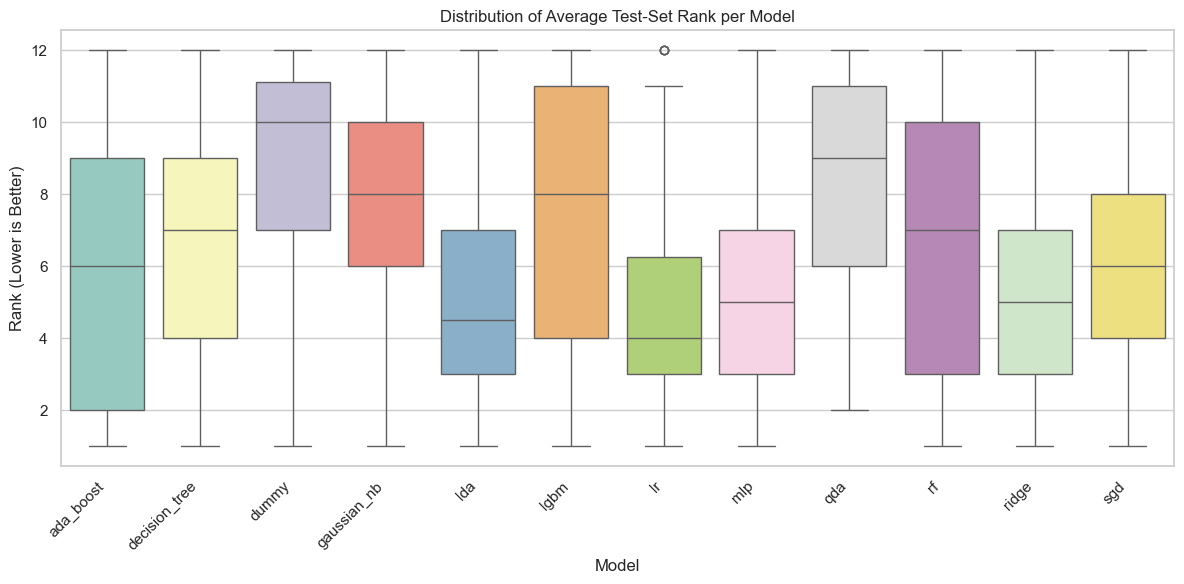

In [14]:
import seaborn as sns
# Define the relevant test metric names
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital']

# Generate the column names that hold test ranks
all_rank_cols = [f"{metric}_test_rank" for metric in statistical_metrics + utility_metrics]

# Reshape the data to long format for seaborn
melted_df = ranked_df[['model'] + all_rank_cols].melt(id_vars='model', var_name='Metric', value_name='Rank')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_df, x='model', y='Rank', palette='Set3')
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Average Test-Set Rank per Model")
plt.ylabel("Rank (Lower is Better)")
plt.xlabel("Model")
plt.tight_layout()

# Save and/or show the plot
# plt.savefig("average_test_rank_boxplot.png", dpi=300)
plt.show()

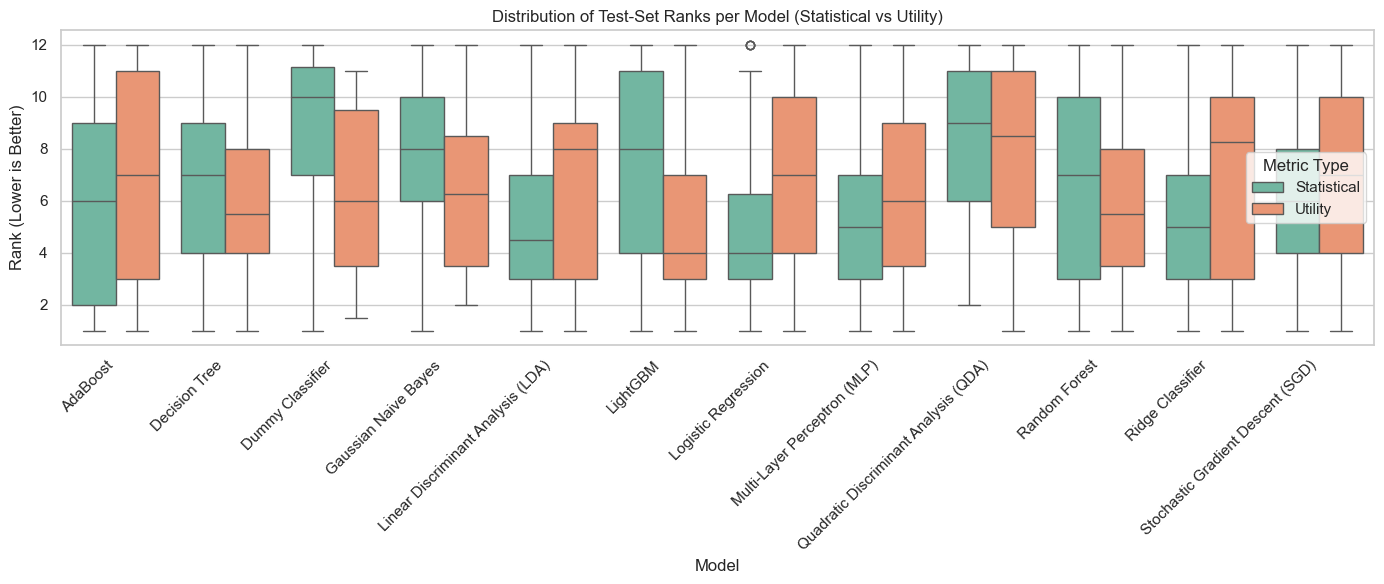

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define metric categories
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital']

# Rank columns
statistical_rank_cols = [f"{metric}_test_rank" for metric in statistical_metrics]
utility_rank_cols = [f"{metric}_test_rank" for metric in utility_metrics]

# Melt and label each part
stat_melted = ranked_df[['model'] + statistical_rank_cols].melt(
    id_vars='model', var_name='Metric', value_name='Rank'
)
stat_melted['Metric Type'] = 'Statistical'

util_melted = ranked_df[['model'] + utility_rank_cols].melt(
    id_vars='model', var_name='Metric', value_name='Rank'
)
util_melted['Metric Type'] = 'Utility'

# Combine the data
combined_melted = pd.concat([stat_melted, util_melted], ignore_index=True)
model_name_map = {
    'ada_boost': 'AdaBoost',
    'decision_tree': 'Decision Tree',
    'dummy': 'Dummy Classifier',
    'gaussian_nb': 'Gaussian Naive Bayes',
    'lda': 'Linear Discriminant Analysis',
    'lgbm': 'LightGBM',
    'lr': 'Logistic Regression',
    'mlp': 'Multi-Layer Perceptron',
    'qda': 'Quadratic Discriminant Analysis',
    'rf': 'Random Forest',
    'ridge': 'Ridge Classifier',
    'sgd': 'Stochastic Gradient Descent'
}

# Apply the mapping
combined_melted['model'] = combined_melted['model'].replace(model_name_map)

# Create the boxplot with hue
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_melted, x='model', y='Rank', hue='Metric Type', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Test-Set Ranks per Model (Statistical vs Utility)")
plt.ylabel("Rank (Lower is Better)")
plt.xlabel("Model")
plt.legend(title='Metric Type')
plt.tight_layout()
# plt.savefig("combined_metric_type_boxplot.png", dpi=300)
plt.show()


In [8]:
def compute_val_vs_test_correlation(df, val_prefix="_val", test_metrics=None):
    import pandas as pd

    if test_metrics is None:
        test_metrics = ['Backtesting Final Value_test', 'Sharpe Ratio_test']

    # Select only the validation metric columns
    val_columns = [col for col in df.columns if col.endswith(val_prefix)]
    
    # Keep only the relevant columns (validation + test targets)
    columns_of_interest = val_columns + test_metrics
    df_corr = df[columns_of_interest].copy()

    # Compute correlations
    correlation_results = {}
    for target in test_metrics:
        corr_series = df_corr.corr(method='spearman')[target][val_columns]
        correlation_results[target] = corr_series

    return pd.DataFrame(correlation_results)


In [9]:
spearman_correlation_df = compute_val_vs_test_correlation(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)

print(spearman_correlation_df)


                                Backtesting Final Value_test  \
AUC_val                                             0.376489   
Accuracy_val                                        0.447550   
Adjusted Expected Return_val                        0.180642   
Backtesting Accuracy_val                            0.300854   
Backtesting Final Value_val                         0.755214   
EPEL_val                                            0.294377   
EV_val                                              0.294377   
Expected Growth Rate_val                            0.181657   
F1 Score_val                                       -0.180018   
Negative Log Loss_val                               0.585257   
Return over Risked Capital_val                      0.583341   
Sharpe Ratio_val                                    0.761680   
Sortino Ratio_val                                   0.781751   

                                Sharpe Ratio_test  
AUC_val                                  0.373958  

In [11]:
def compute_ranked_correlation_by_asset(df, val_prefix="_val", test_metrics=None):
    import pandas as pd

    if test_metrics is None:
        test_metrics = ['Backtesting Final Value_test', 'Sharpe Ratio_test']

    # Identify all validation metric columns
    val_columns = [col for col in df.columns if col.endswith(val_prefix)]

    # All metrics of interest (val + test)
    metric_columns = val_columns + test_metrics

    # Step 1: Rank metrics within each asset
    ranked_df = df.copy()
    for col in metric_columns:
        ranked_df[f"{col}_rank"] = ranked_df.groupby("asset")[col].rank(ascending=False)

    # Step 2: Extract only the ranked columns
    ranked_columns = [f"{col}_rank" for col in metric_columns]
    ranked_data = ranked_df[ranked_columns]

    # Step 3: Compute correlations between val ranks and each test metric rank
    correlation_results = {}
    for test_metric in test_metrics:
        test_rank_col = f"{test_metric}_rank"
        val_rank_cols = [f"{col}_rank" for col in val_columns]
        corr_series = ranked_data[val_rank_cols + [test_rank_col]].corr(method='pearson')[test_rank_col][val_rank_cols]
        correlation_results[test_metric] = corr_series

    return pd.DataFrame(correlation_results)

correlation_df = compute_ranked_correlation_by_asset(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)
correlation_df_60 = compute_ranked_correlation_by_asset(
    df=df_neg_log_loss_60,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)
# correlation_df_90 = compute_ranked_correlation_by_asset(
#     df=df_neg_log_loss_90,
#     val_prefix="_val",
#     test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
# )
print(correlation_df)


                                     Backtesting Final Value_test  \
AUC_val_rank                                             0.201532   
Accuracy_val_rank                                        0.135356   
Adjusted Expected Return_val_rank                       -0.076492   
Backtesting Accuracy_val_rank                            0.111316   
Backtesting Final Value_val_rank                         0.532168   
EPEL_val_rank                                           -0.103332   
EV_val_rank                                             -0.103332   
Expected Growth Rate_val_rank                           -0.076790   
F1 Score_val_rank                                        0.135094   
Negative Log Loss_val_rank                               0.296170   
Return over Risked Capital_val_rank                      0.390043   
Sharpe Ratio_val_rank                                    0.544136   
Sortino Ratio_val_rank                                   0.567056   

                                 

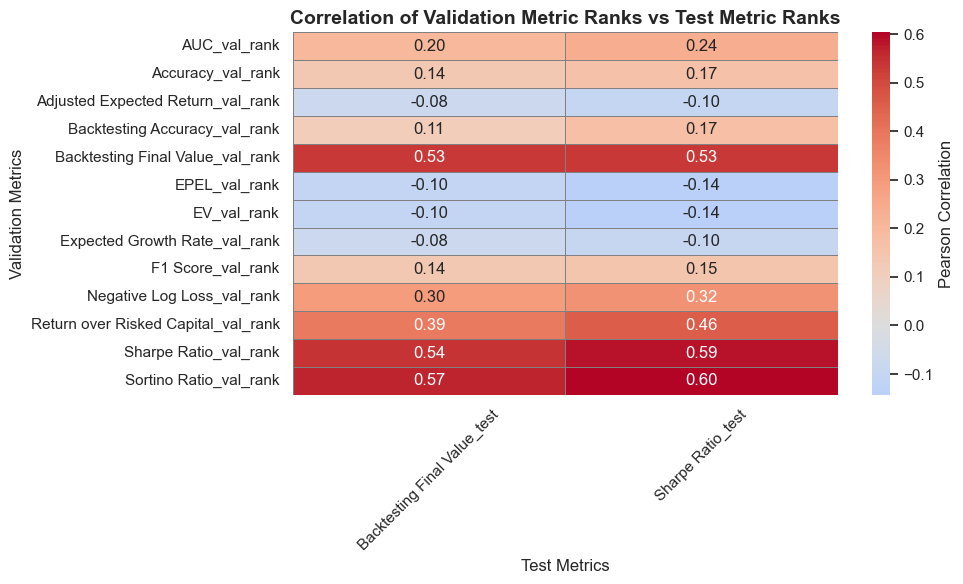

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(correlation_df, title="Correlation of Validation Metric Ranks vs Test Metric Ranks"):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Plot heatmap
    ax = sns.heatmap(
        correlation_df,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Pearson Correlation'}
    )

    plt.title(title, fontsize=14, weight='bold')
    plt.ylabel("Validation Metrics")
    plt.xlabel("Test Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
correlation_df = compute_ranked_correlation_by_asset(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)

plot_correlation_heatmap(correlation_df)


In [100]:
correlation_df

Backtesting Final Value_test  \
AUC_val_rank                                             0.201532   
Accuracy_val_rank                                        0.135356   
Adjusted Expected Return_val_rank                       -0.076492   
Backtesting Accuracy_val_rank                            0.111316   
Backtesting Final Value_val_rank                         0.532168   
Expected Growth Rate_val_rank                           -0.076790   
F1 Score_val_rank                                        0.135094   
Negative Log Loss_val_rank                               0.296170   
Operations %_val_rank                                   -0.077363   
Return over Risked Capital_val_rank                      0.390043   
Sharpe Ratio_val_rank                                    0.544136   
Sortino Ratio_val_rank                                   0.567056   

                                     Sharpe Ratio_test  
AUC_val_rank                                  0.239017  
Accuracy_val_rank                             0.165165  
Adjusted Expected Return_val_rank            -0.099388  
Backtesting Accuracy_val_rank                 0.170749  
Backtesting Final Value_val_rank              0.533284  
Expected Growth Rate_val_rank                -0.097307  
F1 Score_val_rank                             0.147674  
Negative Log Loss_val_rank                    0.323250  
Operations %_val_rank                        -0.105258  
Return over Risked Capital_val_rank           0.460642  
Sharpe Ratio_val_rank                         0.588390  
Sortino Ratio_val_rank                        0.604329

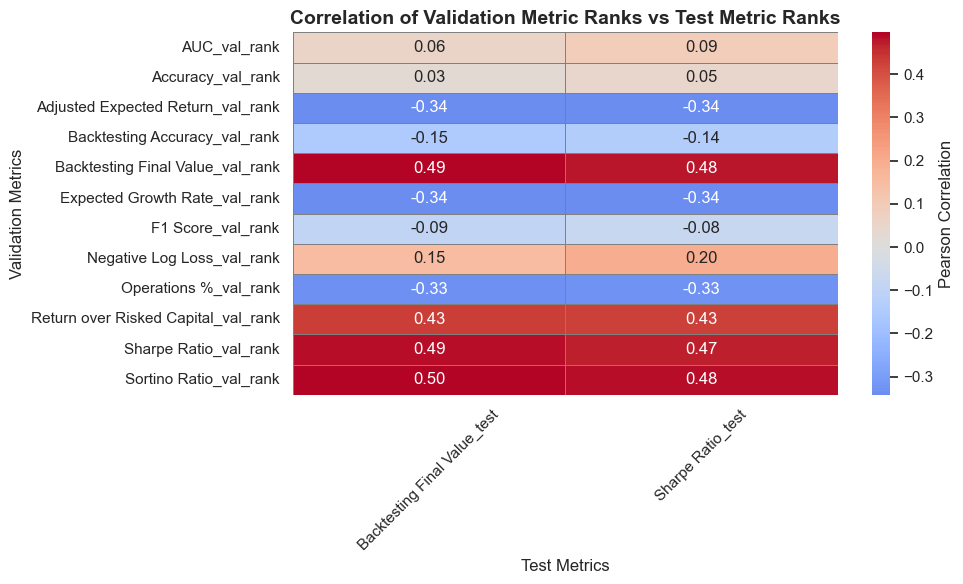

In [96]:
plot_correlation_heatmap(correlation_df_60, title="Correlation of Validation Metric Ranks vs Test Metric Ranks")


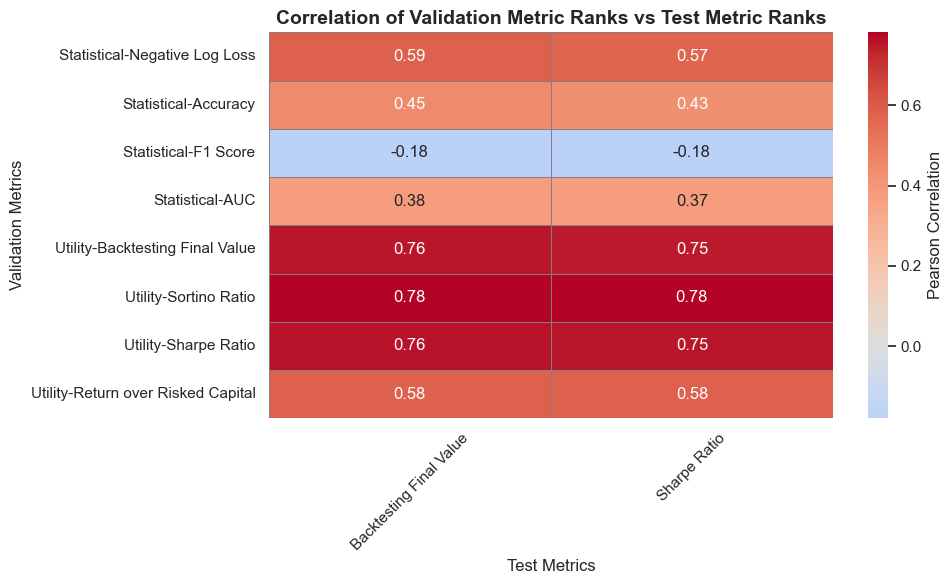

In [91]:
plot_correlation_heatmap(spearman_correlation_df)


In [88]:
spearman_correlation_df

Backtesting Final Value_test  \
AUC_val                                             0.376489   
Accuracy_val                                        0.447550   
Adjusted Expected Return_val                        0.180642   
Backtesting Accuracy_val                            0.300854   
Backtesting Final Value_val                         0.755214   
Expected Growth Rate_val                            0.181657   
F1 Score_val                                       -0.180018   
Negative Log Loss_val                               0.585257   
Operations %_val                                    0.205800   
Return over Risked Capital_val                      0.583341   
Sharpe Ratio_val                                    0.761680   
Sortino Ratio_val                                   0.781751   

                                Sharpe Ratio_test  
AUC_val                                  0.373958  
Accuracy_val                             0.431864  
Adjusted Expected Return_val             0.151117  
Backtesting Accuracy_val                 0.293891  
Backtesting Final Value_val              0.745188  
Expected Growth Rate_val                 0.152189  
F1 Score_val                            -0.177693  
Negative Log Loss_val                    0.570326  
Operations %_val                         0.175741  
Return over Risked Capital_val           0.581893  
Sharpe Ratio_val                         0.754858  
Sortino Ratio_val                        0.779662

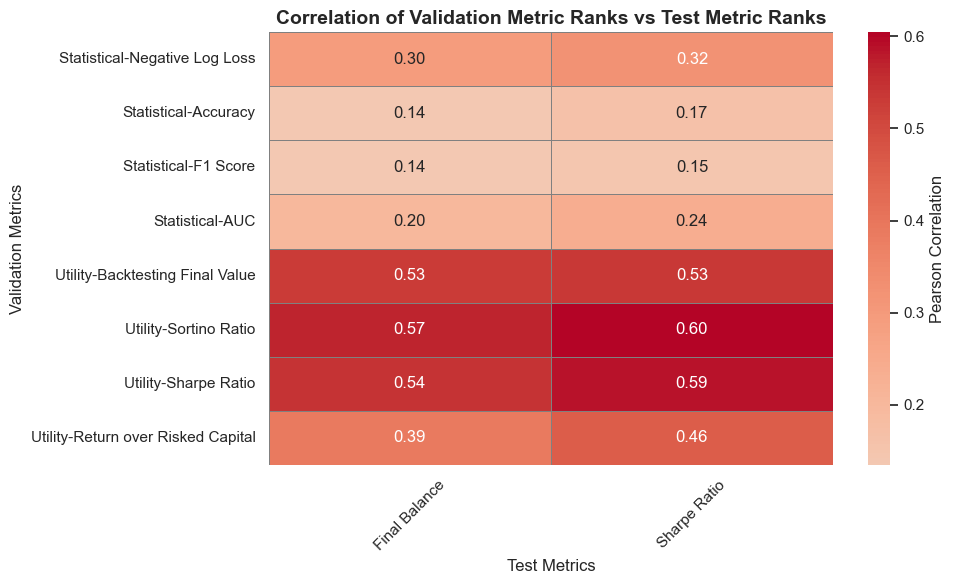

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample: correlation_df = compute_val_vs_test_correlation(...)

plot_df = correlation_df.copy()
# 1. Define metric groups
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital']

# 2. Create label mapping (strip _val/_test)
clean_index = {f"{m}_val_rank": m for m in statistical_metrics + utility_metrics}
clean_columns = {
    'Backtesting Final Value_test': 'Final Balance',
    'Sharpe Ratio_test': 'Sharpe Ratio'
}

# 3. Rename both index and columns
plot_df.rename(index=clean_index, columns=clean_columns, inplace=True)

# 4. Reorder the DataFrame using cleaned labels
ordered_index = statistical_metrics + utility_metrics
ordered_columns = ['Final Balance', 'Sharpe Ratio']
plot_df = plot_df.loc[ordered_index, ordered_columns]

# 5. Optional: Grouping for visual clarity
group_labels = ['Statistical'] * len(statistical_metrics) + ['Utility'] * len(utility_metrics)
plot_df.index = pd.MultiIndex.from_arrays([group_labels, plot_df.index])

# 6. Plot heatmap
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.heatmap(
    plot_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Pearson Correlation'}
)
plt.title("Correlation of Validation Metric Ranks vs Test Metric Ranks", fontsize=14, weight='bold')
plt.xlabel("Test Metrics")
plt.ylabel("Validation Metrics")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


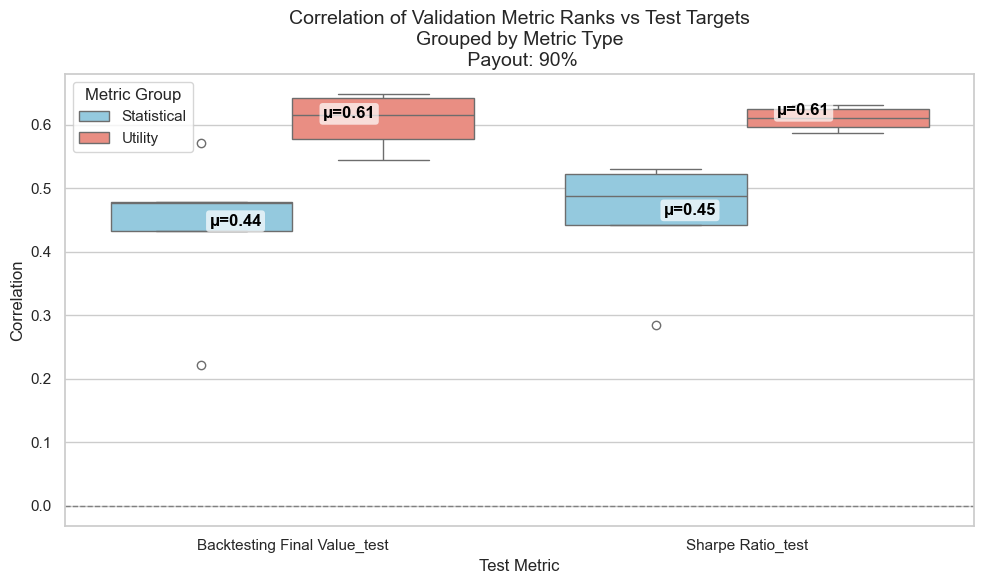

In [45]:
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital']
def classify_metric(metric_name, stat_list, util_list):
    for stat in stat_list:
        if stat in metric_name:
            return 'Statistical'
    for util in util_list:
        if util in metric_name:
            return 'Utility'
    return 'Other'

def prepare_grouped_correlation_df(df, val_prefix="_val", test_metrics=None):
    corr_df = compute_ranked_correlation_by_asset(
        df, val_prefix=val_prefix, test_metrics=test_metrics
    ).reset_index().rename(columns={"index": "Metric"})

    melted = corr_df.melt(id_vars="Metric", var_name="Test Metric", value_name="Correlation")
    melted["Metric Group"] = melted["Metric"].apply(
        lambda x: classify_metric(x, statistical_metrics, utility_metrics)
    )
    return melted


def plot_correlation_by_group(corr_melted_df, payout):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    palette = {
    "Statistical": "skyblue",
    "Utility": "salmon",
    "Other": "lightgray"  # fallback color
    }
    corr_melted_df=corr_melted_df[corr_melted_df["Metric Group"] != "Other"]
    ax = sns.boxplot(
        x="Test Metric",
        y="Correlation",
        hue="Metric Group",
        data=corr_melted_df,
        palette=palette,
    )

    # Calculate and add mean value labels for each group
    for i, test_metric in enumerate(corr_melted_df["Test Metric"].unique()):
        metric_data = corr_melted_df[corr_melted_df["Test Metric"] == test_metric]
        
        for j, group in enumerate(metric_data["Metric Group"].unique()):
            group_data = metric_data[metric_data["Metric Group"] == group]
            mean_val = group_data["Correlation"].mean()
            
            # Find the position on the x-axis
            x_pos = i + (j - 0.5) * 0.25  # Adjust this value based on your box positions
            
            # Add text label with the mean value
            ax.text(x_pos, mean_val, f"μ={mean_val:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title(f"Correlation of Validation Metric Ranks vs Test Targets\nGrouped by Metric Type\n Payout: {payout}%", fontsize=14)
    plt.axhline(0, linestyle="--", color="gray", linewidth=1)
    plt.tight_layout()
    plt.legend(title="Metric Group")
    plt.show()
test_targets = ['Backtesting Final Value_test', 'Sharpe Ratio_test']

corr_melted_df = prepare_grouped_correlation_df(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=test_targets
)

plot_correlation_by_group(corr_melted_df, payout=90)


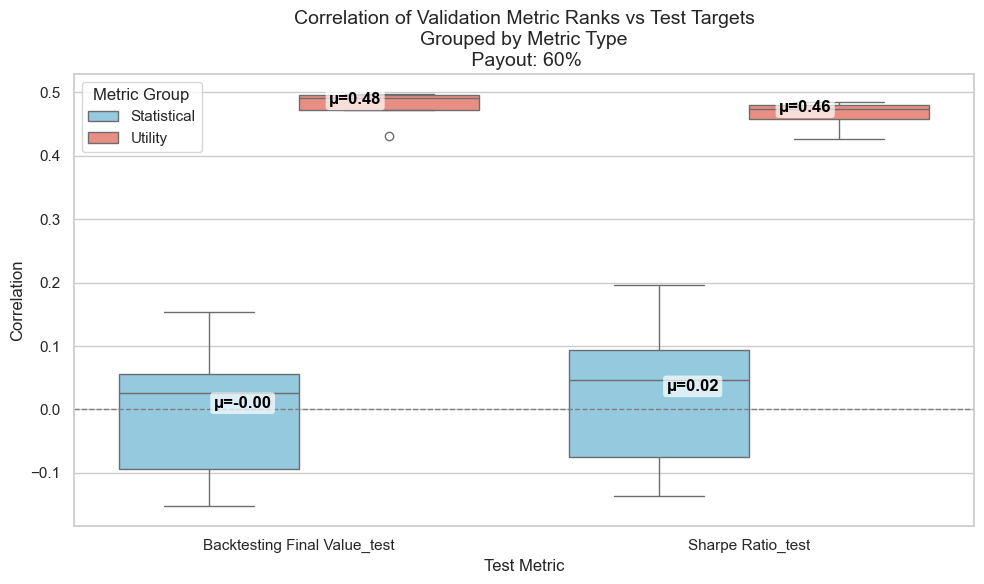

In [46]:
corr_melted_df_60 = prepare_grouped_correlation_df(
    df=df_neg_log_loss_60,
    val_prefix="_val",
    test_metrics=test_targets
)

plot_correlation_by_group(corr_melted_df_60, payout=60)

In [115]:
def calculate_correlation(df, feature_columns, target_column, method):
    results = []
    
    for asset_type, group in df.groupby("fake_type"):
        group = group.dropna(subset=feature_columns + [target_column])
        
        if len(group) >= 3:
            correlations = {}
            p_values = {}
            
            for feature in feature_columns:
                x = group[feature]
                y = group[target_column]
                
                if method == 'pearson':
                    corr, p = pearsonr(x, y)
                elif method == 'spearman':
                    corr, p = spearmanr(x, y)
                elif method == 'kendall':
                    corr, p = kendalltau(x, y)
                elif method == 'mutual_info':
                    corr = mutual_info_regression(x.to_frame(), y, discrete_features=False)[0]
                    p = np.nan  # MI has no p-value
                else:
                    raise ValueError("Unknown method: " + method)
                
                correlations[feature] = corr
                p_values[feature] = p
            
            max_corr_feature = max(correlations.items(), key=lambda x: abs(x[1]))[0]
        else:
            correlations = {feature: np.nan for feature in feature_columns}
            p_values = {feature: np.nan for feature in feature_columns}
            max_corr_feature = None
        
        results.append({
            "asset_type": asset_type,
            **{f"corr_{feature}": correlations[feature] for feature in feature_columns},
            **{f"pval_{feature}": p_values[feature] for feature in feature_columns},
            "most_correlated": max_corr_feature
        })
    
    return pd.DataFrame(results)

def plot_correlation(df, feature_columns, title):
    x = np.arange(len(df))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = []
    
    for i, feature in enumerate(feature_columns):
        bars.append(ax.bar(x + i * width, df[f"corr_{feature}"], width, label=feature))
    
    ax.set_ylabel('Correlation')
    ax.set_title(title)
    ax.set_xticks(x + width * (len(feature_columns) / 2))
    ax.set_xticklabels(df["asset_type"], rotation=45, ha='right')
    ax.legend()
    
    # Add p-values if present
    if f"pval_{feature_columns[0]}" in df.columns:
        for i, asset_type in enumerate(df["asset_type"]):
            for j, feature in enumerate(feature_columns):
                ax.text(bars[j][i].get_x() + bars[j][i].get_width()/2, bars[j][i].get_height(),
                        f"p={df[f'pval_{feature}'][i]:.3f}", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()



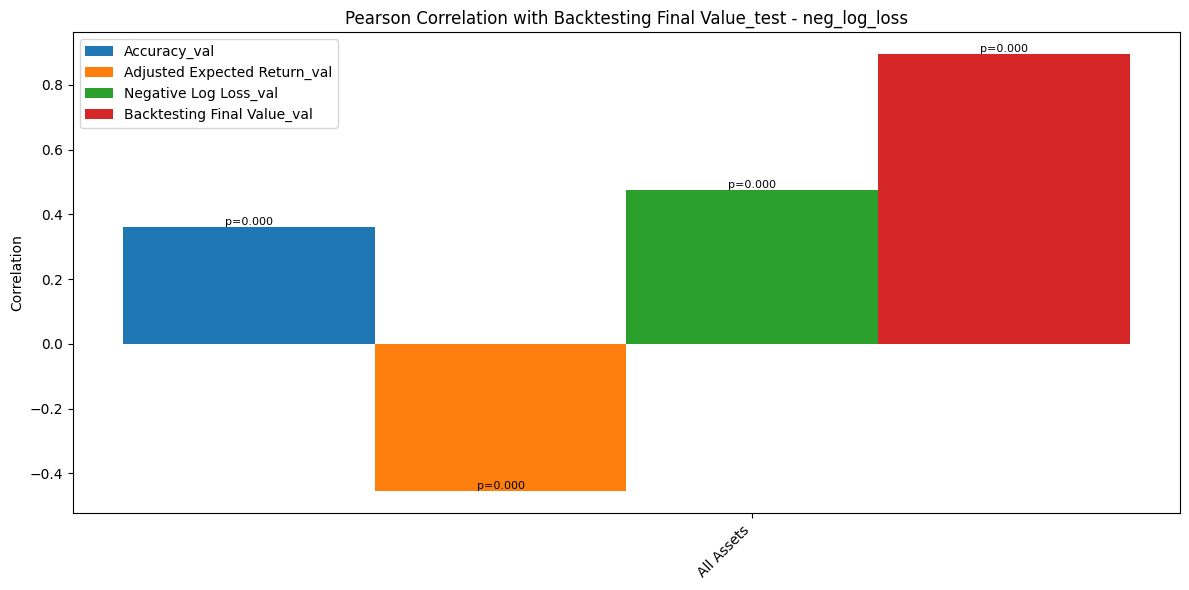

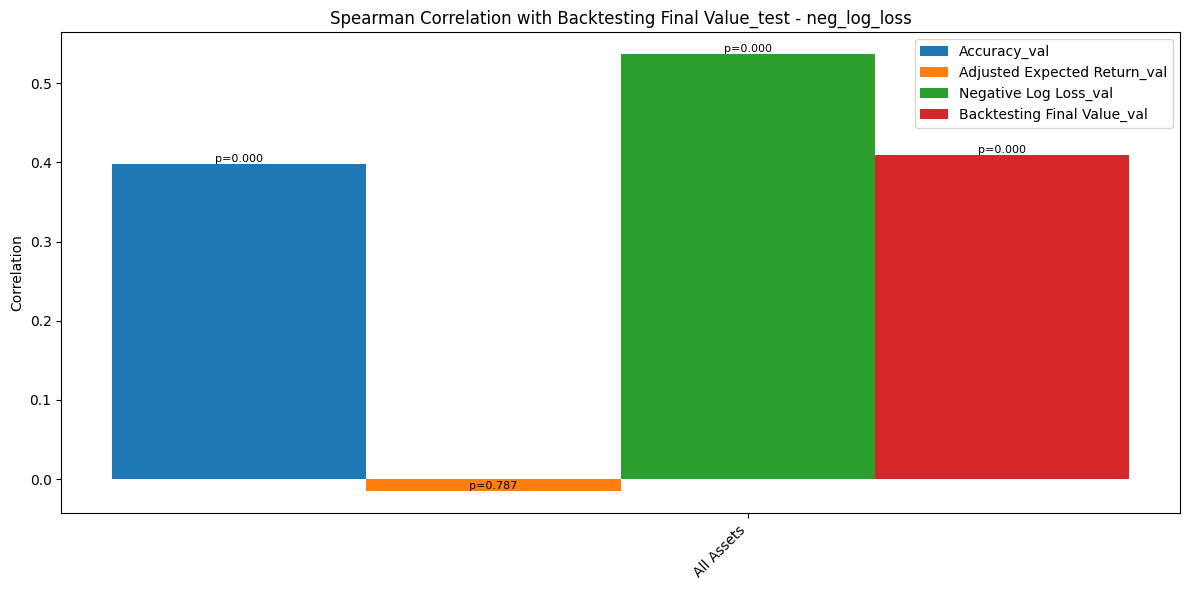

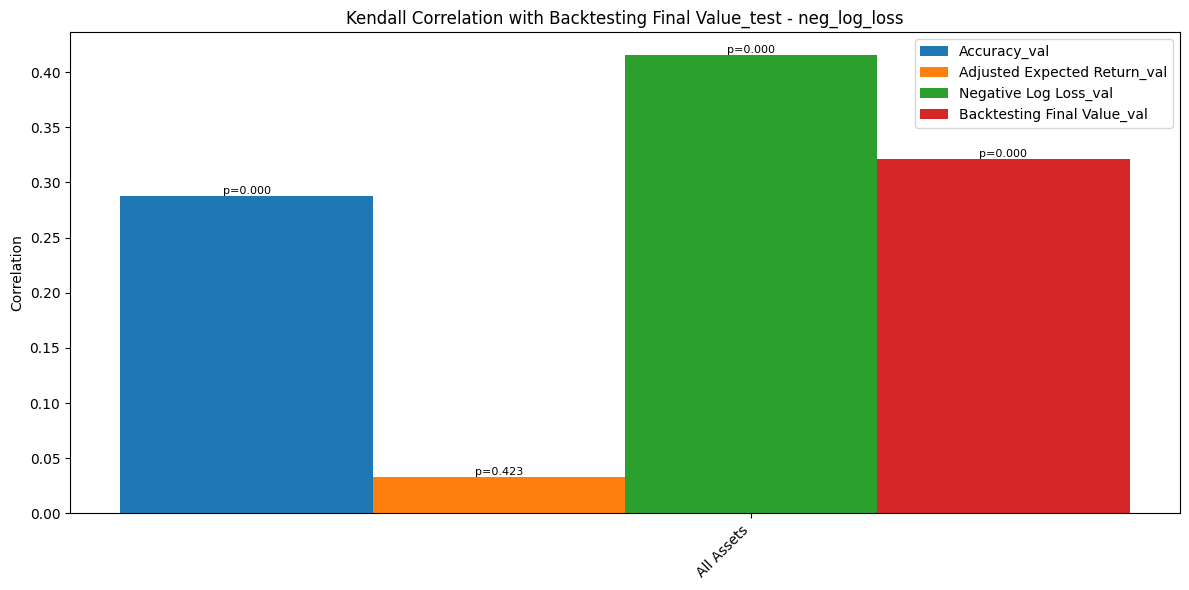

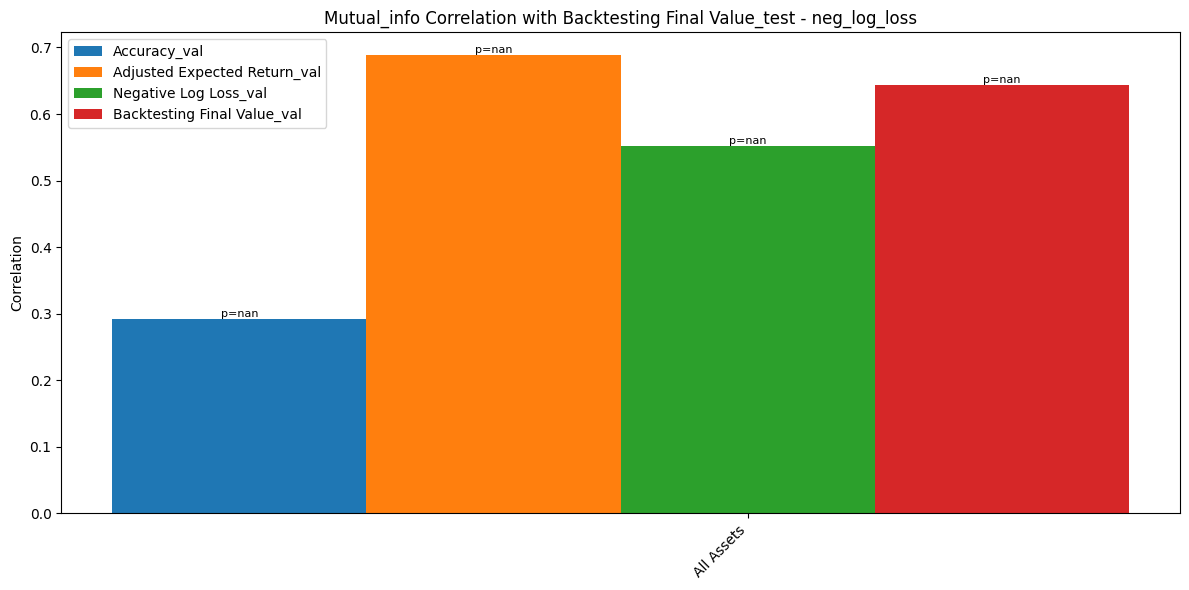

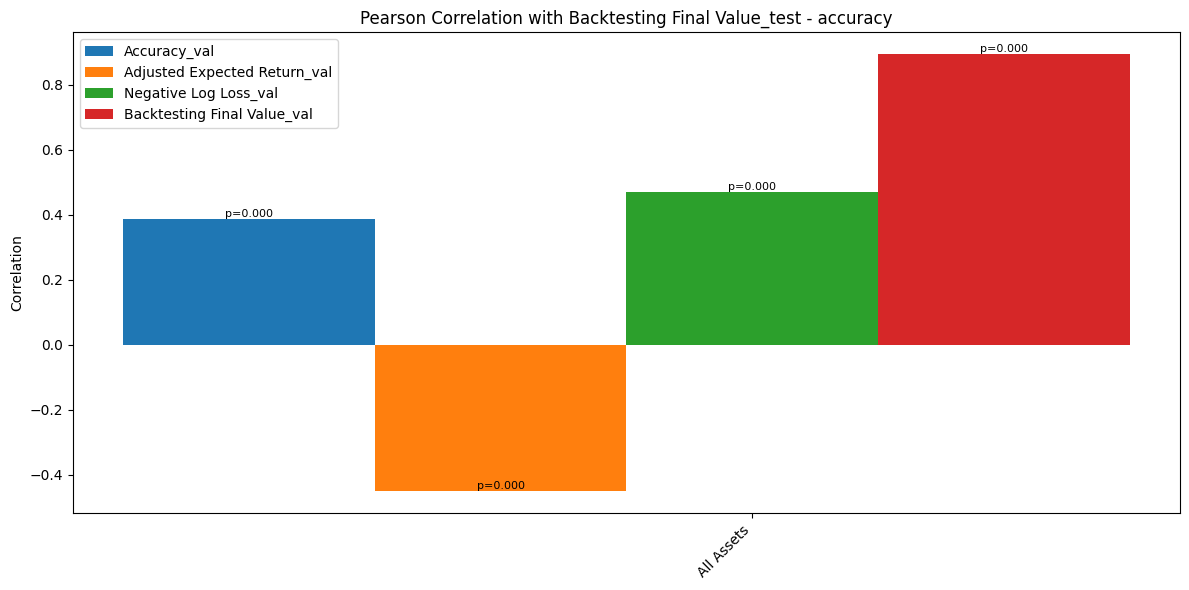

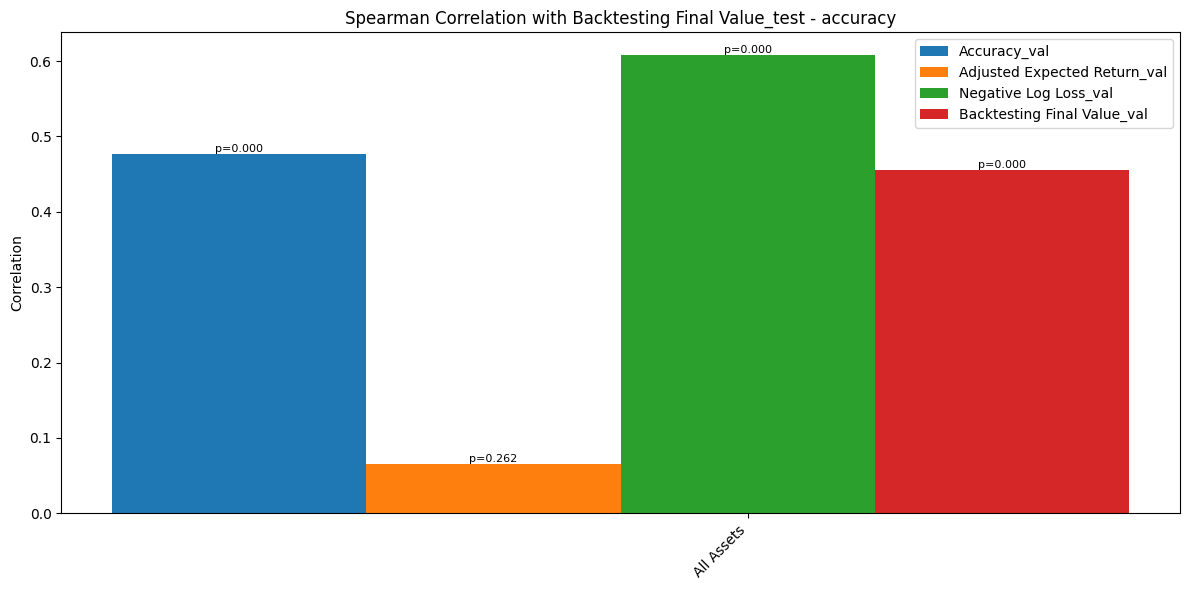

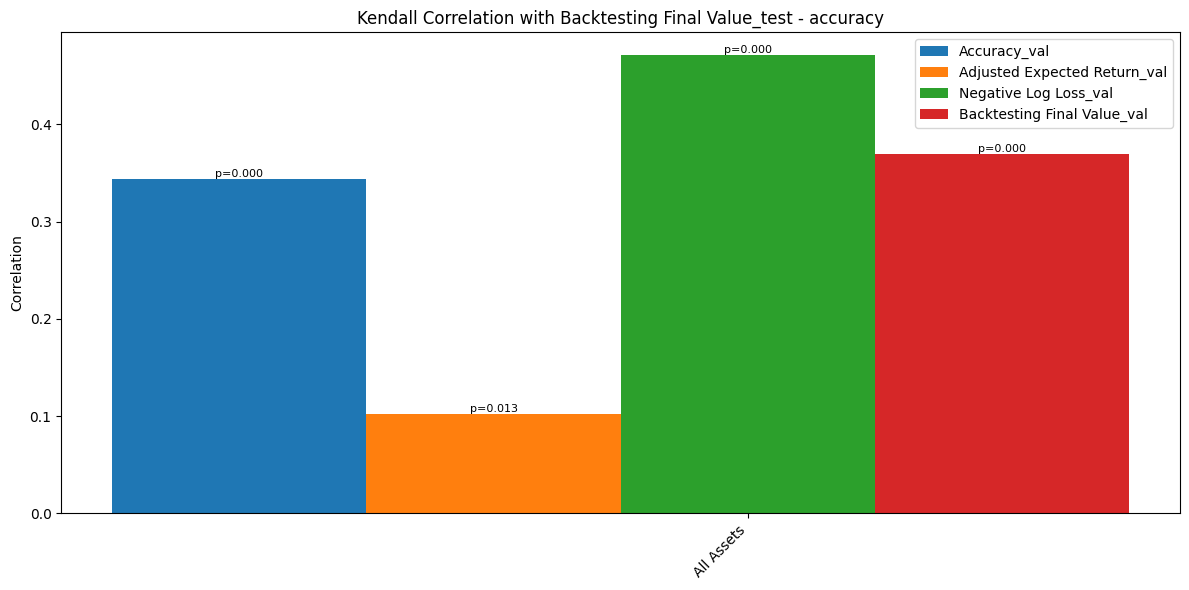

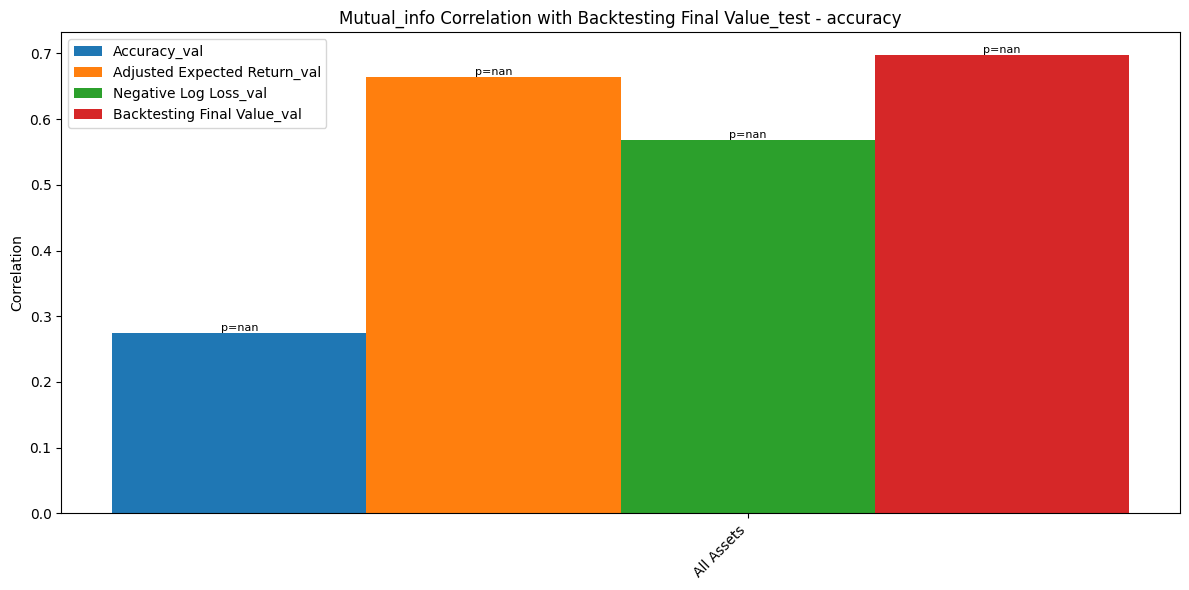

In [74]:
# Example usage:
feature_columns = ["Accuracy_val", "Adjusted Expected Return_val", "Negative Log Loss_val", "Backtesting Final Value_val"]
target_column = "Backtesting Final Value_test"

for name, df in [("neg_log_loss", df_neg_log_loss), ("accuracy", df_accuracy)]:
    for method in ["pearson", "spearman", "kendall", "mutual_info"]:
        result_df = calculate_correlation(df, feature_columns, target_column, method)
        plot_correlation(result_df, feature_columns, f"{method.capitalize()} Correlation with {target_column} - {name}")

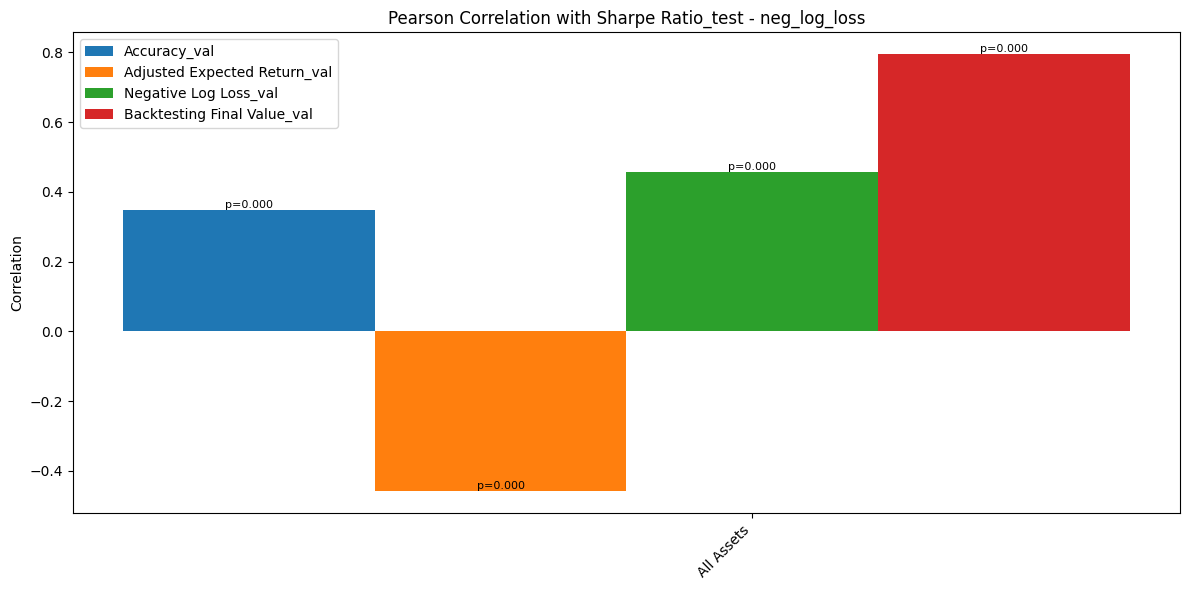

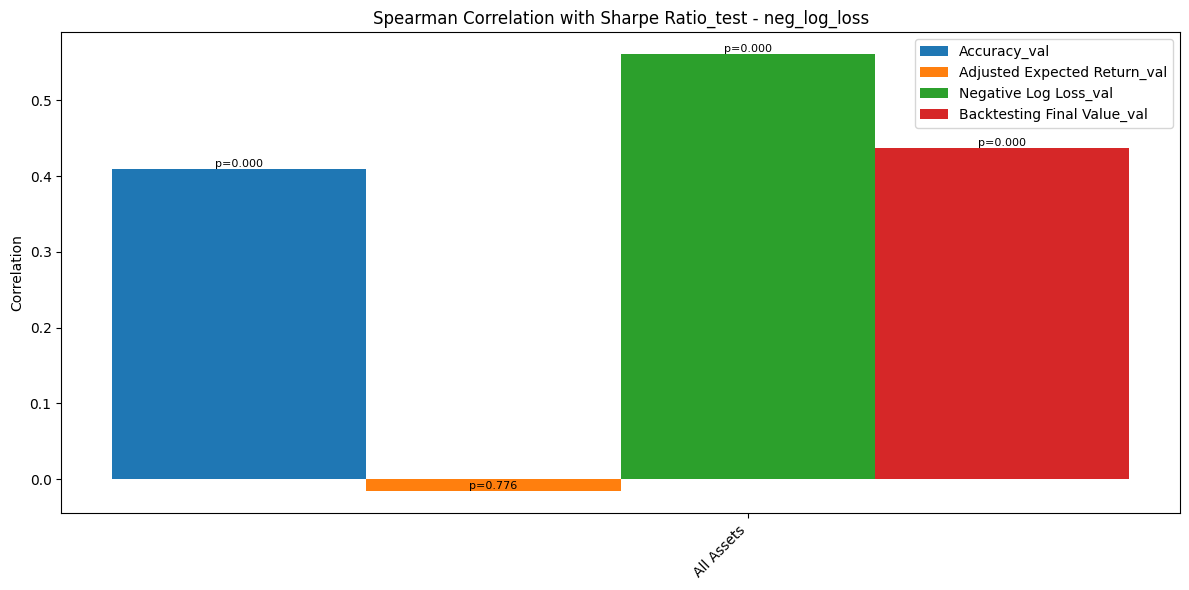

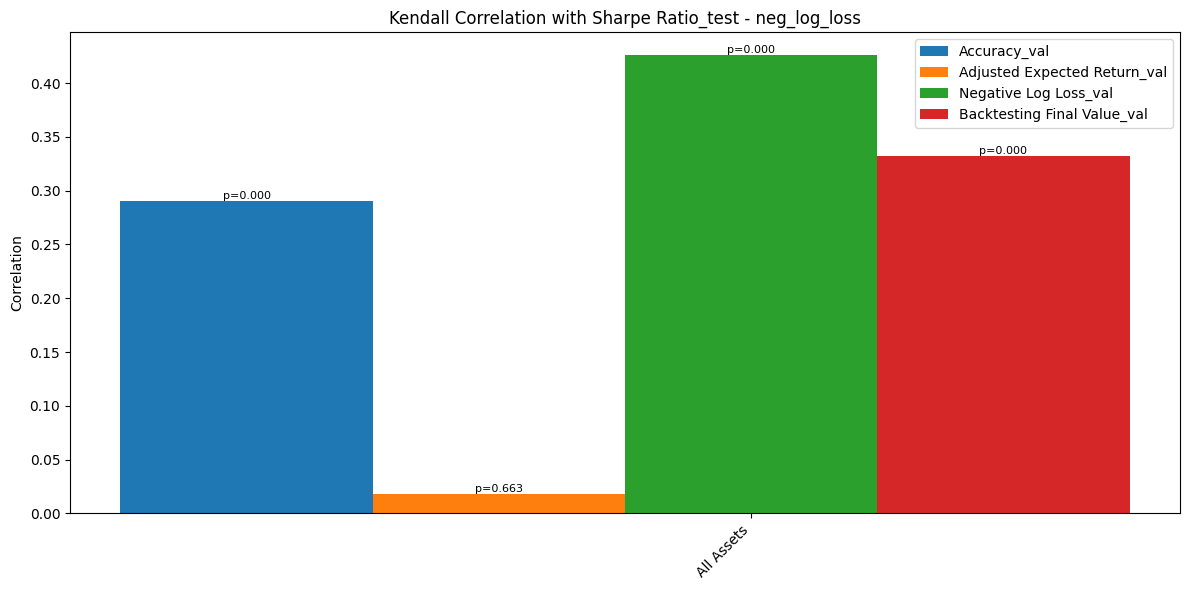

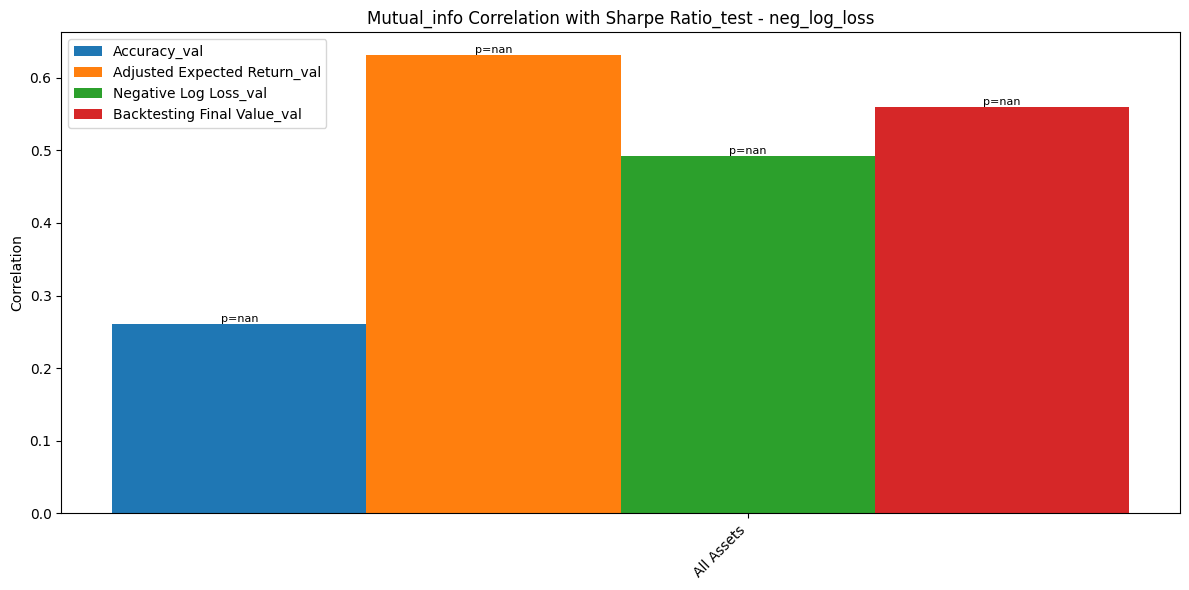

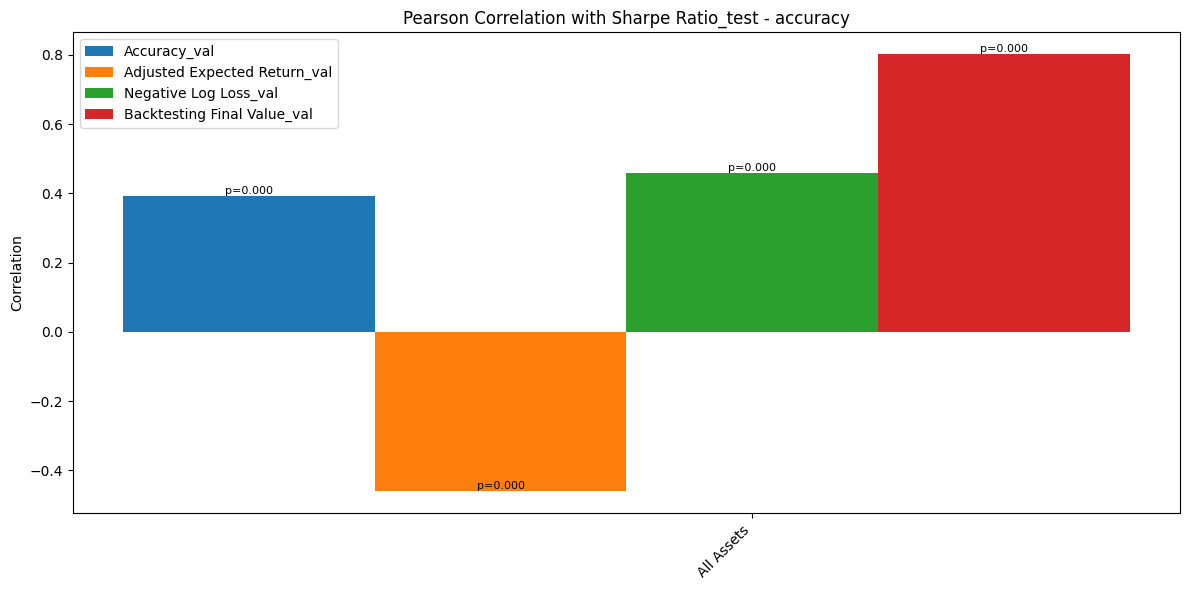

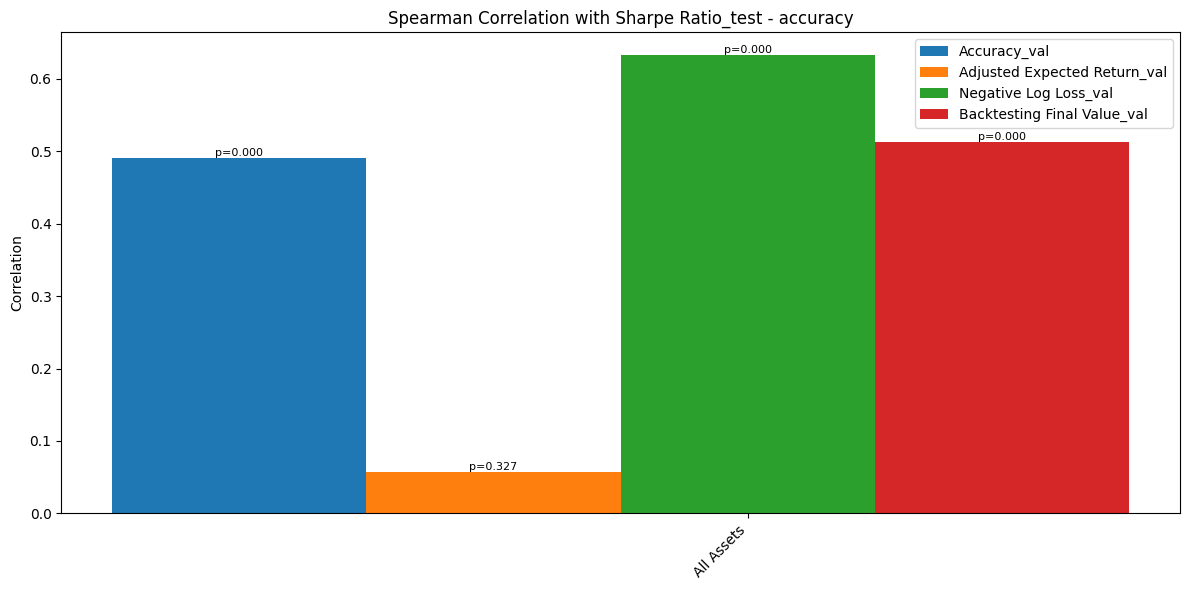

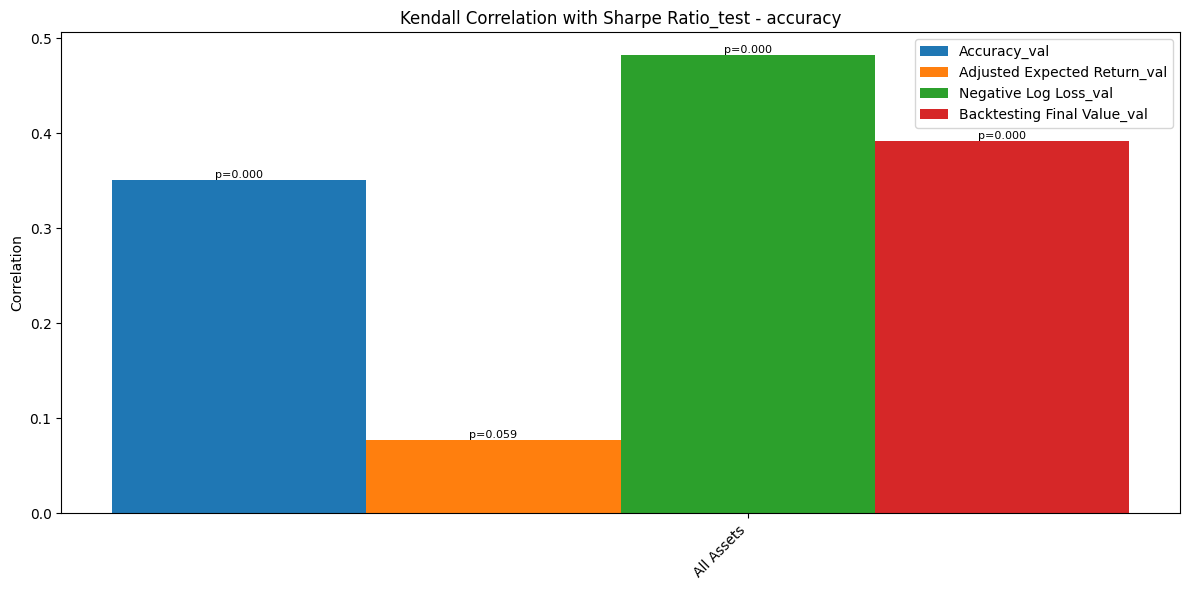

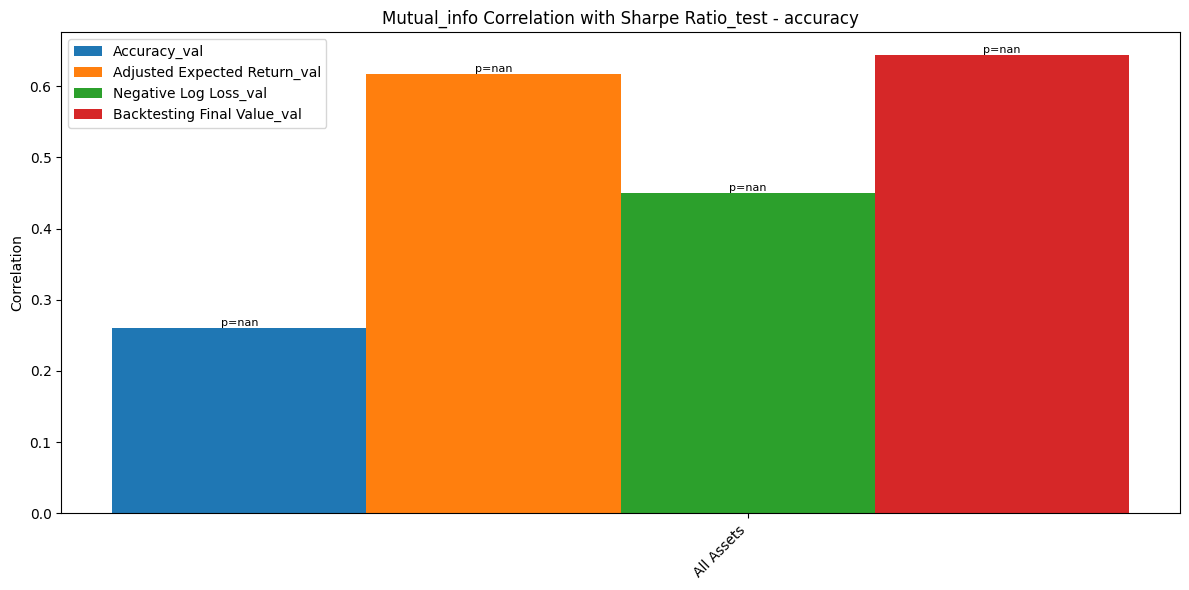

In [75]:
# Example usage:
feature_columns = ["Accuracy_val", "Adjusted Expected Return_val", "Negative Log Loss_val", "Backtesting Final Value_val"]
target_column = "Sharpe Ratio_test"

for name, df in [("neg_log_loss", df_neg_log_loss), ("accuracy", df_accuracy)]:
    for method in ["pearson", "spearman", "kendall", "mutual_info"]:
        result_df = calculate_correlation(df, feature_columns, target_column, method)
        plot_correlation(result_df, feature_columns, f"{method.capitalize()} Correlation with {target_column} - {name}")

In [62]:
metrics_val = ["Accuracy", "Adjusted Expected Return", "Negative Log Loss", "F1 Score", "Backtesting Final Value"]
metrics_test = ["Backtesting Final Value", "Backtesting Accuracy", "Sharpe Ratio", "Sortino Ratio",]
metrics_val = [ text + "_val" for text in metrics_val]
metrics_test = [ text + "_val" for text in metrics_test]
metrics = metrics_val + metrics_test

In [ ]:

def get_ranking(df, metrics):
    # Group by model and compute mean
    grouped = df.groupby("model")[metrics].mean(numeric_only=True)
    
    # Rank each metric (lower is better for Negative Log Loss, higher is better for others)
    ranking = pd.DataFrame(index=grouped.index)
    
    for metric in metrics:
        ascending = metric == "Negative Log Loss"
        ranking[f'{metric} Rank'] = grouped[metric].rank(ascending=ascending, method='min')
    
    # Optional: Calculate an overall average rank
    ranking['Average Rank'] = ranking.mean(axis=1)
    
    # Reset index to make 'model' a column
    ranking.reset_index(inplace=True)
    return ranking

get_ranking(df_accuracy, metrics)
get_ranking(df_neg_log_loss, metrics)


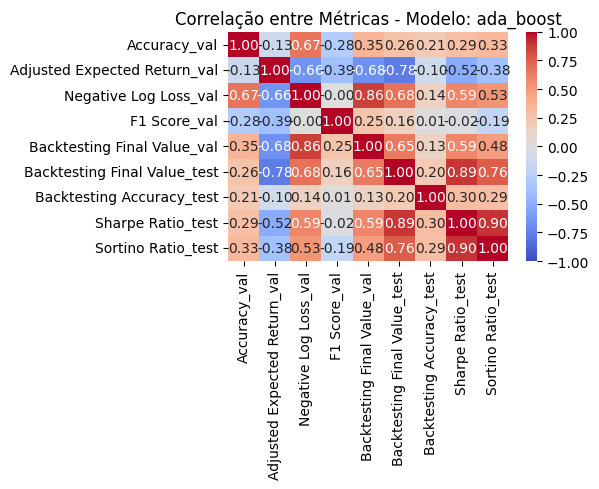

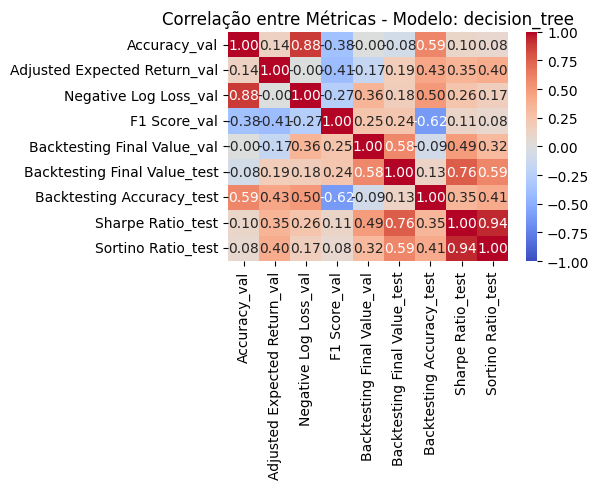

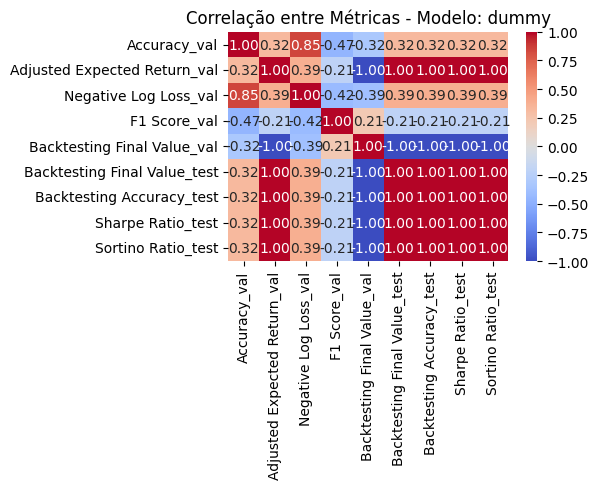

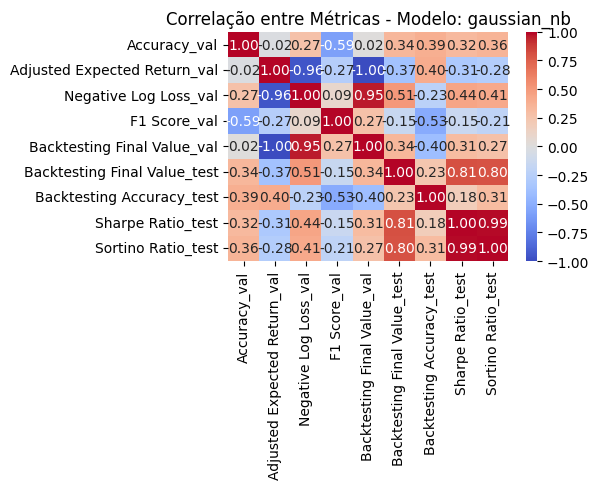

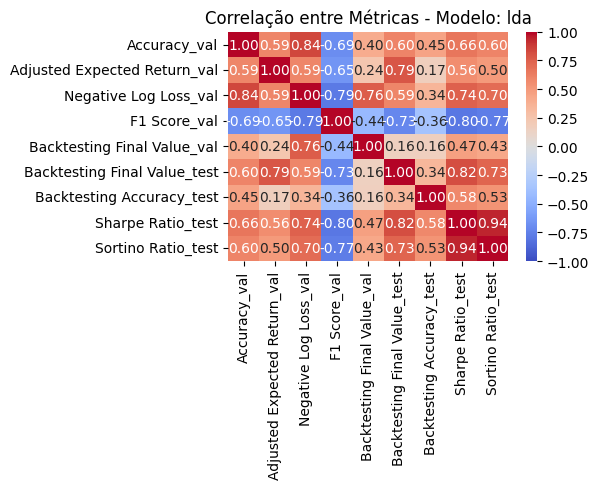

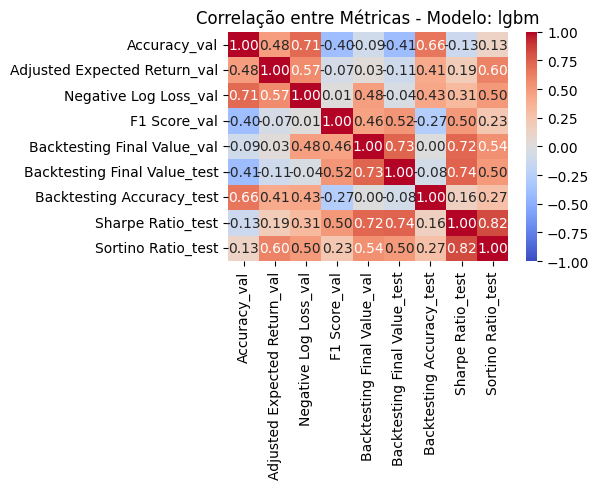

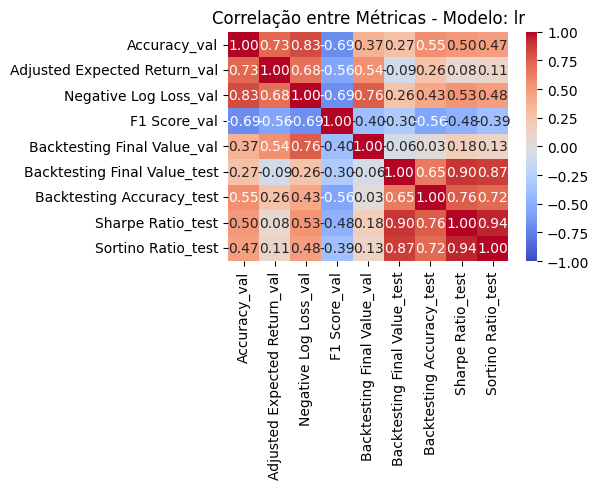

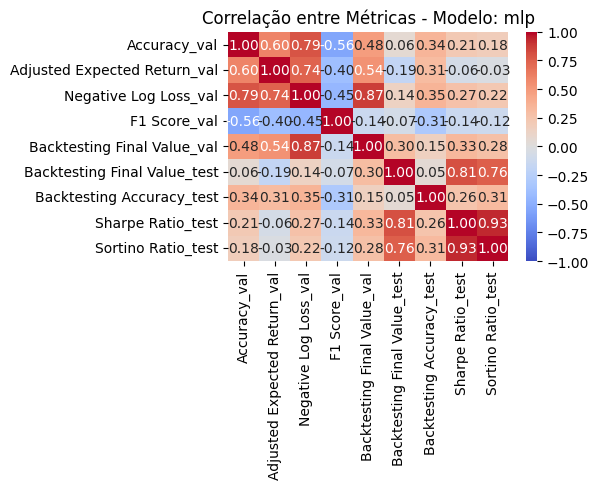

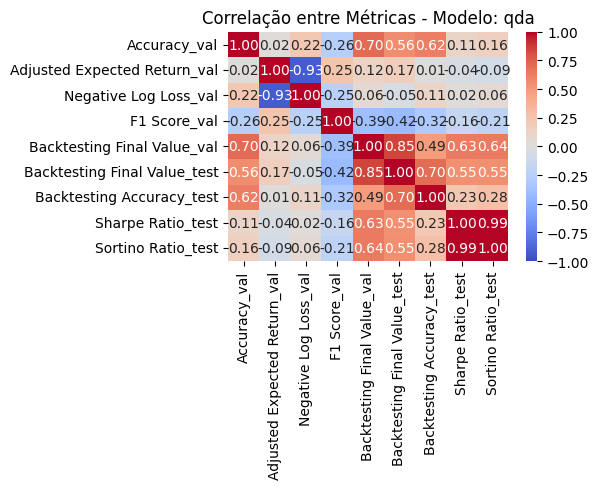

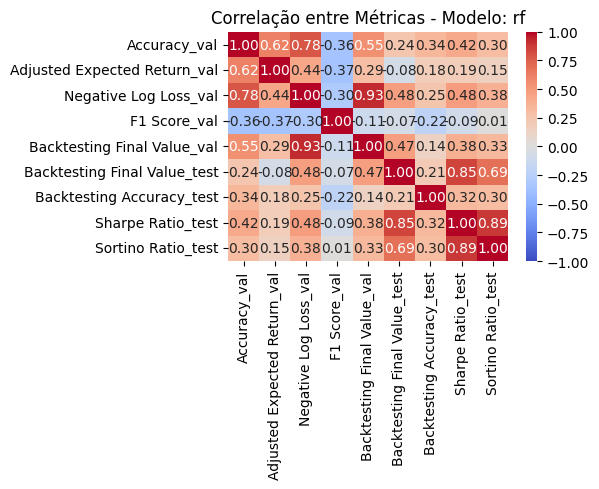

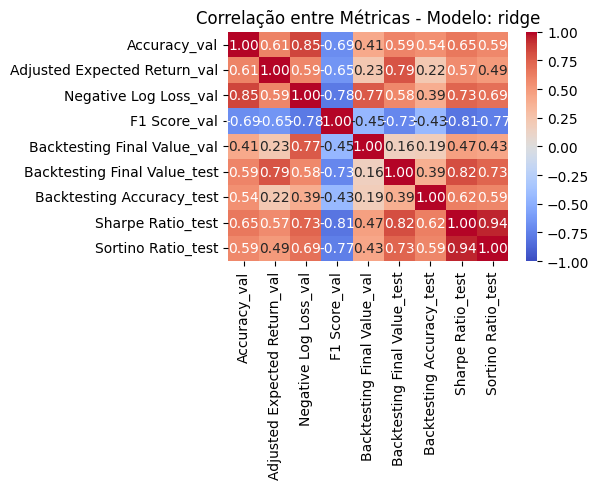

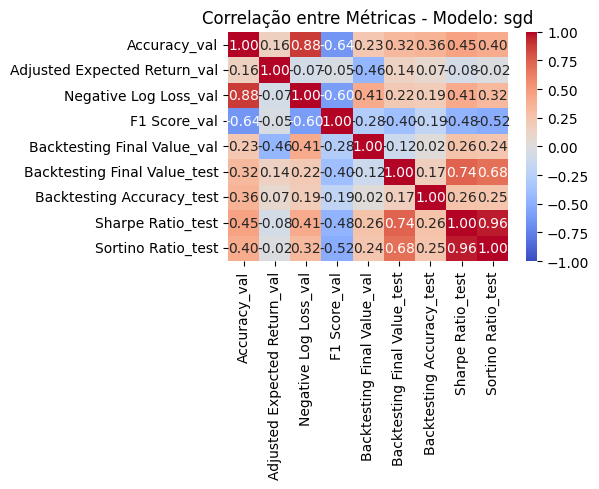

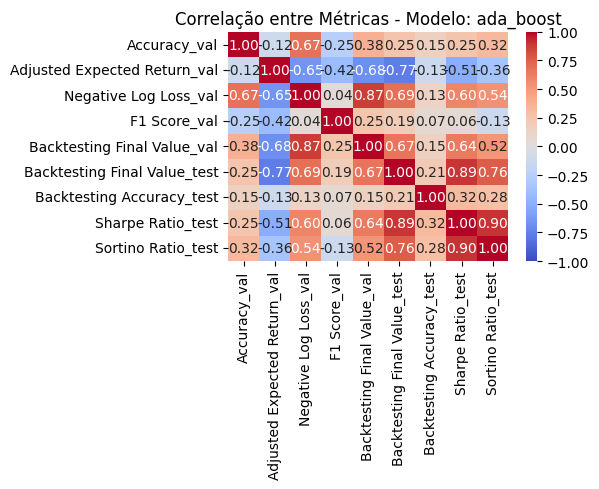

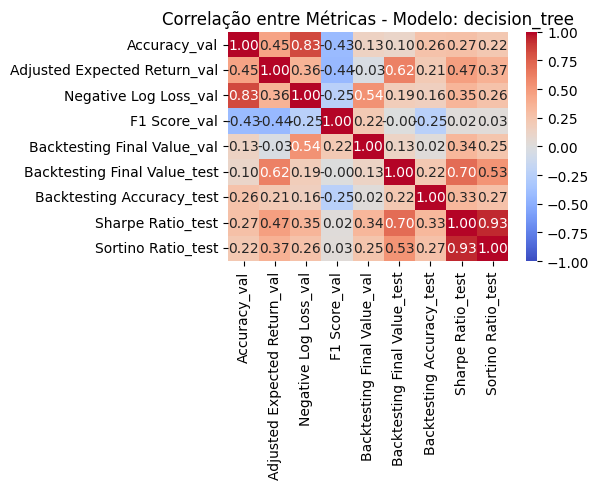

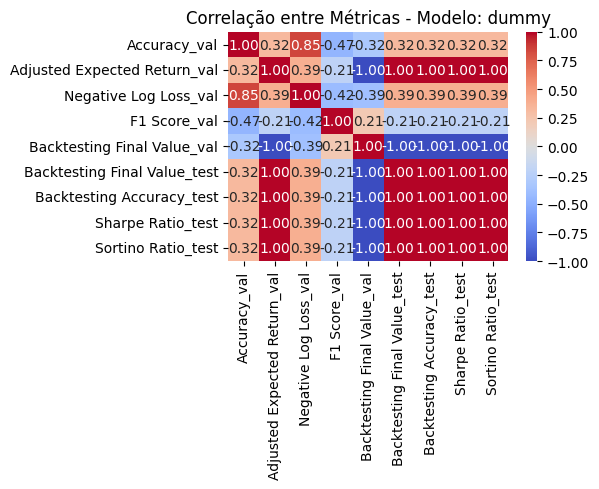

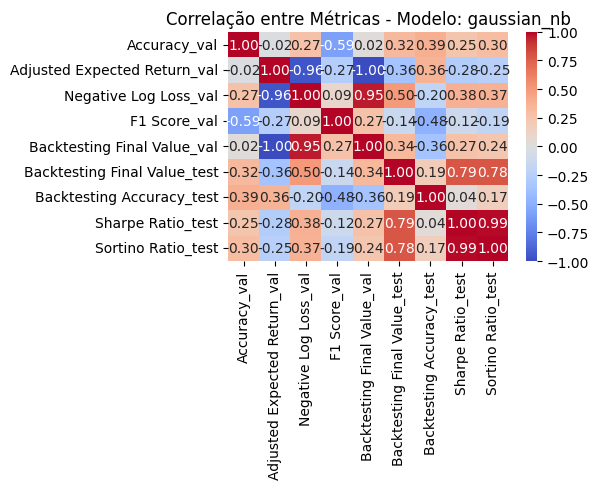

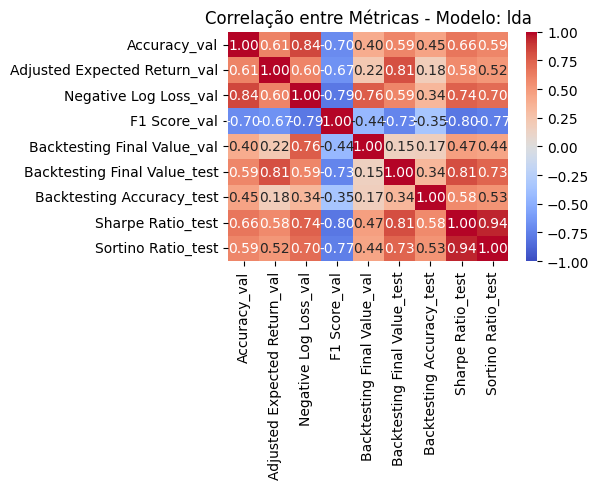

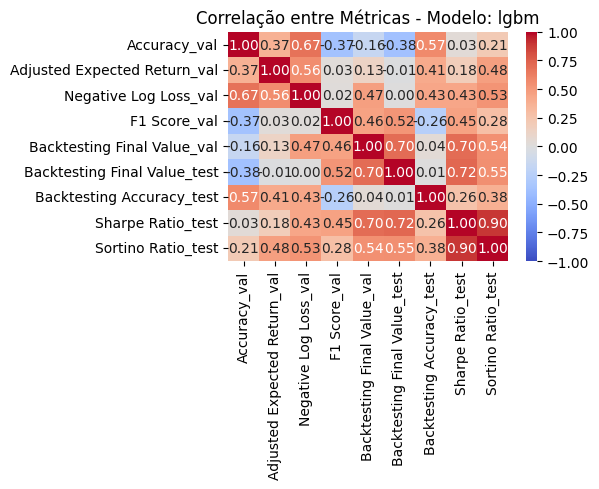

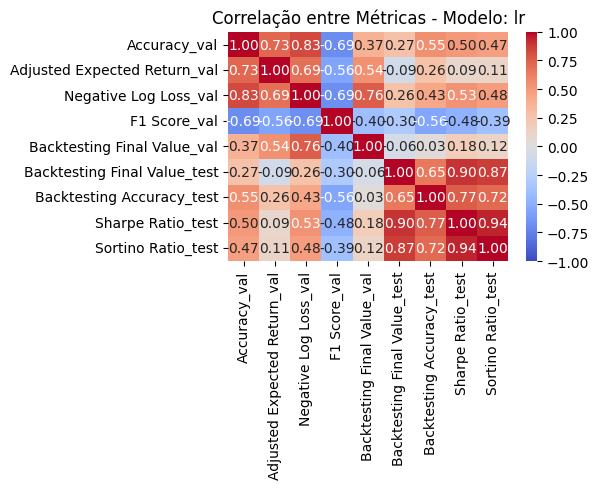

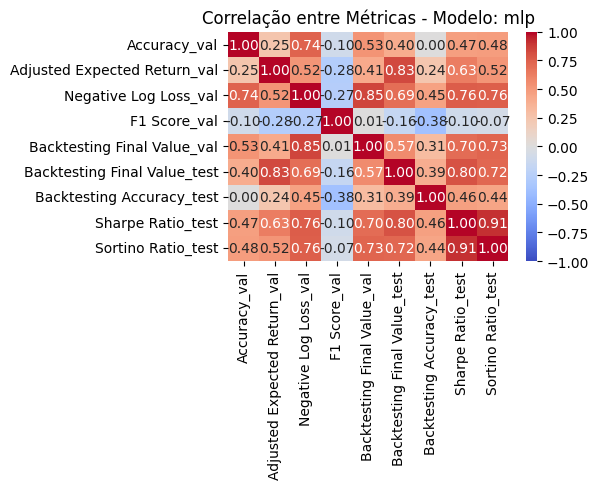

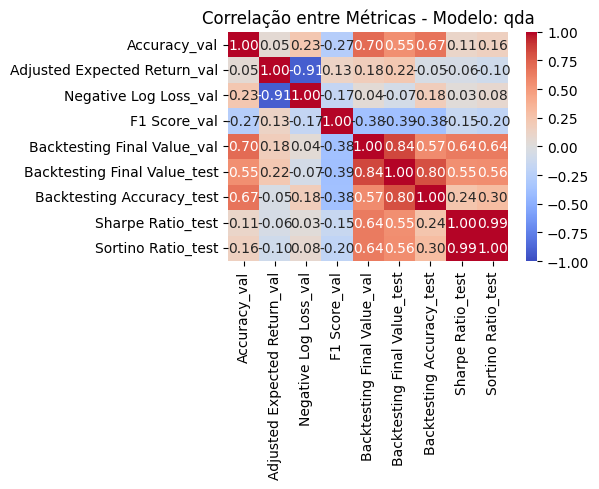

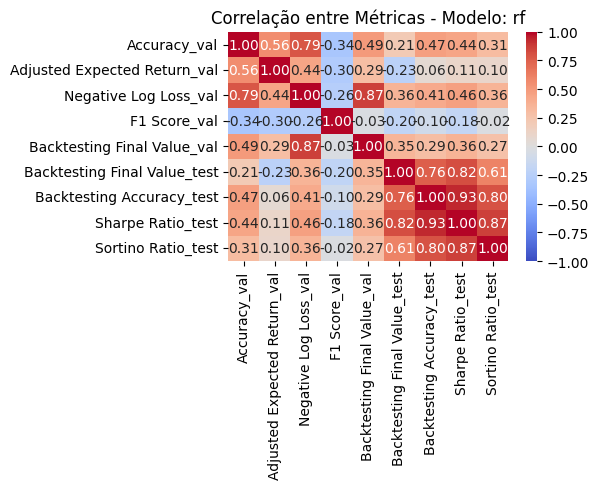

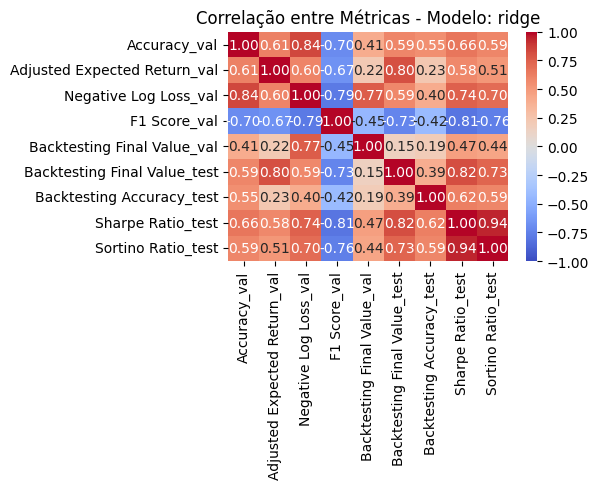

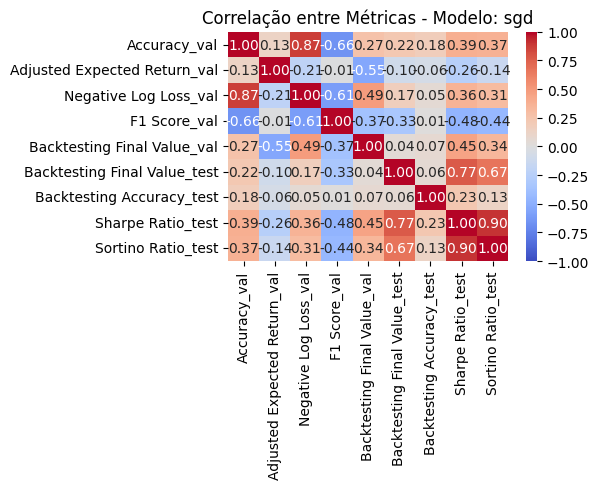

In [78]:
import seaborn as sns


def plot_correlation_heatmaps(df):
    for model_name, group in df.groupby("model"):
        corr = group[metrics].corr()

        plt.figure(figsize=(6, 5))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(f'Correlação entre Métricas - Modelo: {model_name}')
        plt.tight_layout()
        plt.show()

plot_correlation_heatmaps(df_neg_log_loss)
plot_correlation_heatmaps(df_accuracy)


In [79]:

import seaborn as sns

def plot_model_average_metrics(model_name, df):
    model_df = df[df['model'] == model_name]
    means = model_df[metrics].mean()

    fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(7, 1.5 * len(metrics)))

    for i, metric in enumerate(metrics):
        axes[i].bar(metric, means[metric])
        axes[i].set_title(f'{metric}')
        axes[i].set_ylabel('Média')
        axes[i].set_ylim(min(0, means[metric] * 0.9), means[metric] * 1.1)

    fig.suptitle(f"Média das métricas - Modelo: {model_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_model_metric_variability(model_name, df):
    model_df = df[df['model'] == model_name]

    fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(7, 1.5 * len(metrics)))

    for i, metric in enumerate(metrics):
        sns.boxplot(data=model_df[[metric]], ax=axes[i])
        axes[i].set_title(f'Variabilidade - {metric}')
        axes[i].set_ylabel(metric)

    fig.suptitle(f"Variabilidade das métricas - Modelo: {model_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Step 1: Label the source of each metric DataFrame
df_neg_log_loss["metric_type"] = "Negative Log Loss"
df_accuracy["metric_type"] = "Accuracy"

# Step 2: Concatenate them
combined_df = pd.concat([df_neg_log_loss, df_accuracy], ignore_index=True)



def plot_combined_model_average_metrics(model_name, combined_df):
    model_df = combined_df[combined_df['model'] == model_name]
    grouped = model_df.groupby("metric_type")[metrics].mean().T  # Transposed for easier plotting

    for metric in grouped.index:
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x=grouped.columns, y=grouped.loc[metric].values)
        plt.title(f"Média da métrica '{metric}' - Modelo: {model_name}")
        plt.ylabel("Valor Médio")
        plt.xlabel("Tipo de Métrica")

        # Annotate bars
        for i, value in enumerate(grouped.loc[metric].values):
            ax.text(i, value, f'{value:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.show()


def plot_combined_model_metric_variability(model_name, combined_df):
    model_df = combined_df[combined_df['model'] == model_name]

    for metric in metrics:
        plt.figure(figsize=(10, 5))
        ax = sns.boxplot(data=model_df, x="metric_type", y=metric)

        for i, metric_type in enumerate(model_df["metric_type"].unique()):
            subset = model_df[model_df["metric_type"] == metric_type]
            value = subset[metric].mean()
            ax.text(i, value, f'{value:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

        plt.title(f'Variabilidade de "{metric}" - Modelo: {model_name}')
        plt.ylabel(metric)
        plt.xlabel("Tipo de Métrica")
        plt.tight_layout()
        plt.show()


def plot_combined_average_metrics_all_models(combined_df):
    grouped = combined_df.groupby(["model", "metric_type"])[metrics].mean().reset_index()
    melted = grouped.melt(id_vars=["model", "metric_type"], var_name="metric", value_name="value")

    for metric in metrics:
        plt.figure(figsize=(12, 6))
        data = melted[melted['metric'] == metric]
        ax = sns.barplot(data=data, x="model", y="value", hue="metric_type")
        plt.title(f"Média da métrica '{metric}' por modelo (Comparação entre tipos)")
        plt.ylabel(metric)
        plt.xticks(rotation=90)

        # Annotate bars
        for container in ax.containers:
            ax.bar_label(container, fmt="%.4f", fontsize=8)

        plt.tight_layout()
        plt.show()


def plot_average_metrics_all_models(df):
    grouped = df.groupby("model")[metrics].mean().reset_index()
    melted = grouped.melt(id_vars="model", var_name="metric", value_name="value")

    for metric in metrics:
        plt.figure(figsize=(10, 5))
        data = melted[melted['metric'] == metric]
        ax = sns.barplot(data=data, x="model", y="value")
        plt.title(f"Média da métrica '{metric}' por modelo")
        plt.ylabel(metric)
        plt.xticks(rotation=90)

        # Annotate bars
        for container in ax.containers:
            ax.bar_label(container, fmt="%.4f", fontsize=8)

        plt.tight_layout()
        plt.show()


In [80]:
metrics

['Accuracy_val',
 'Adjusted Expected Return_val',
 'Negative Log Loss_val',
 'F1 Score_val',
 'Backtesting Final Value_val',
 'Backtesting Final Value_test',
 'Backtesting Accuracy_test',
 'Sharpe Ratio_test',
 'Sortino Ratio_test']

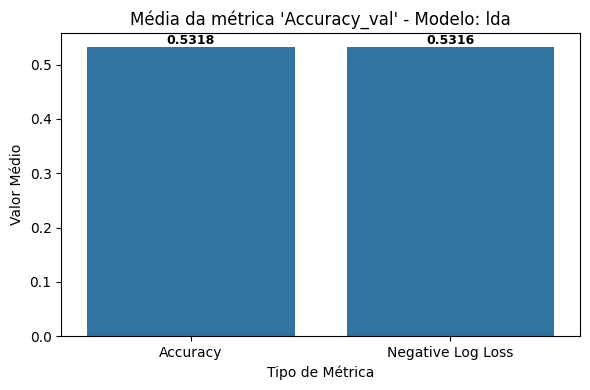

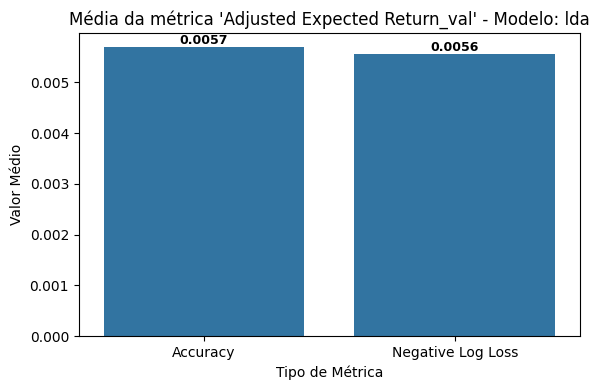

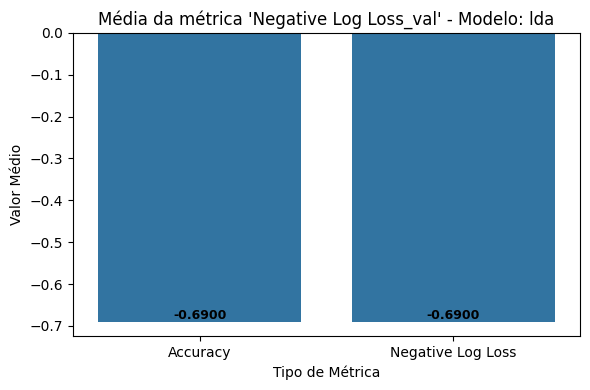

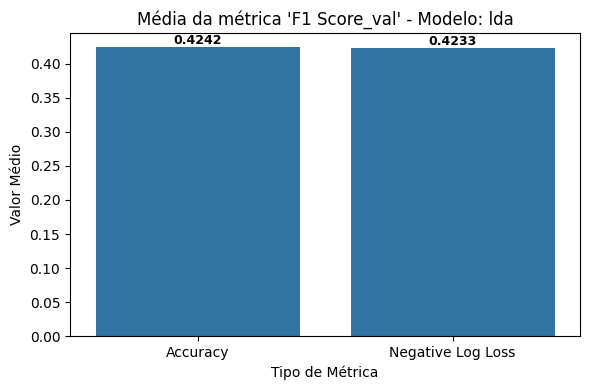

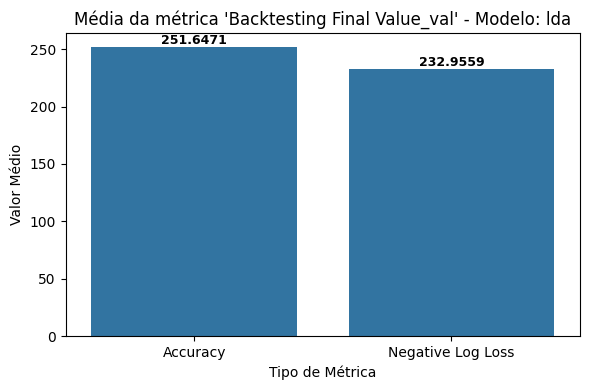

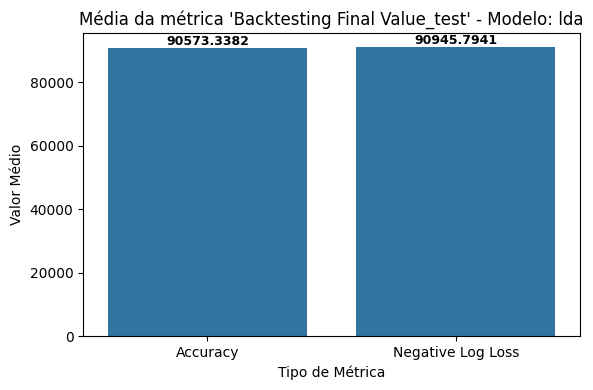

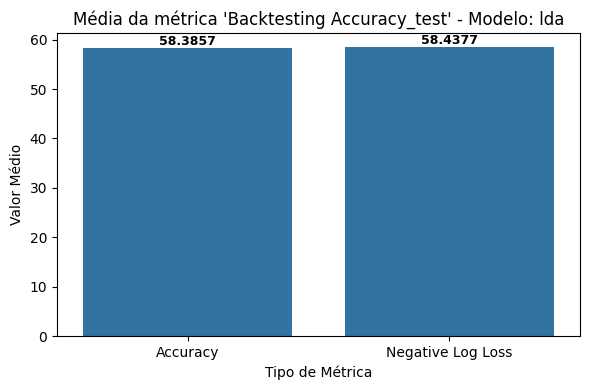

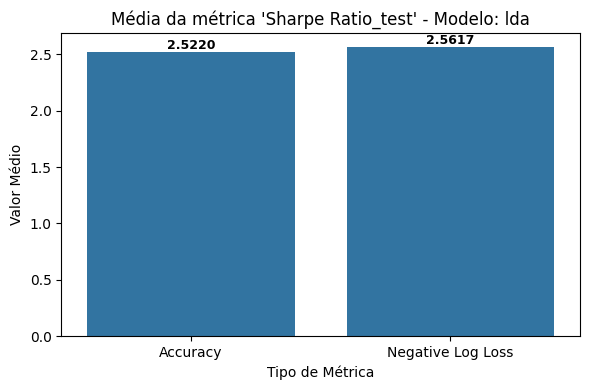

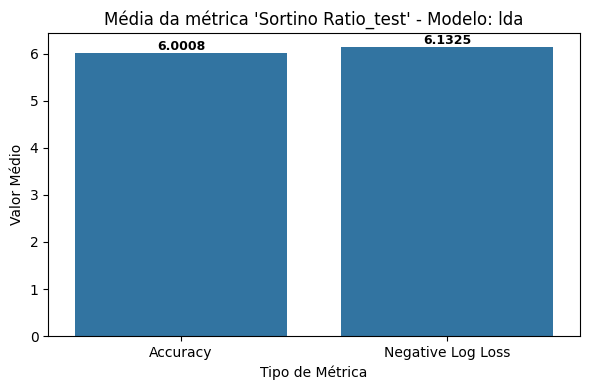

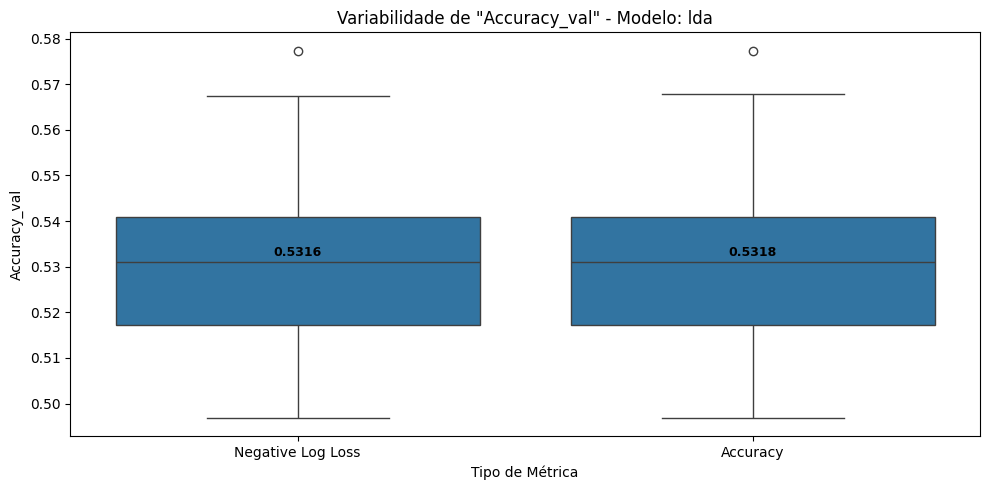

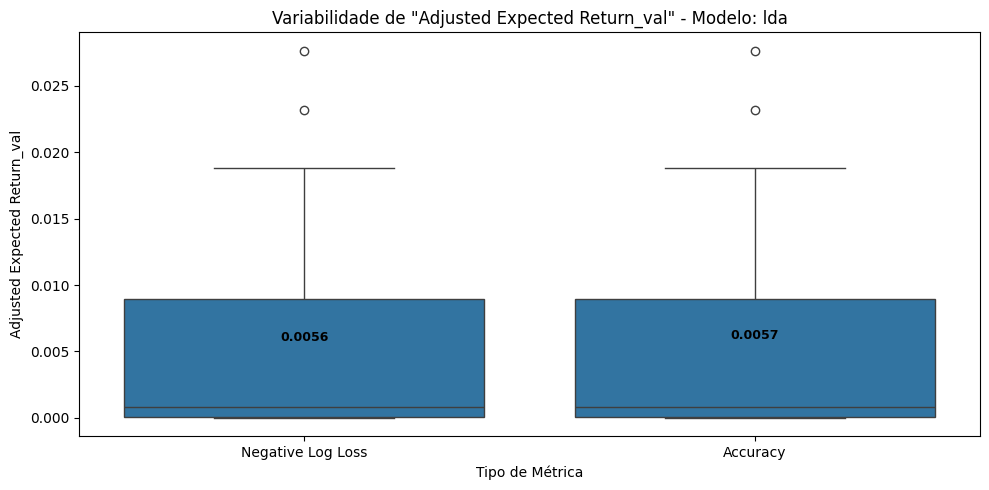

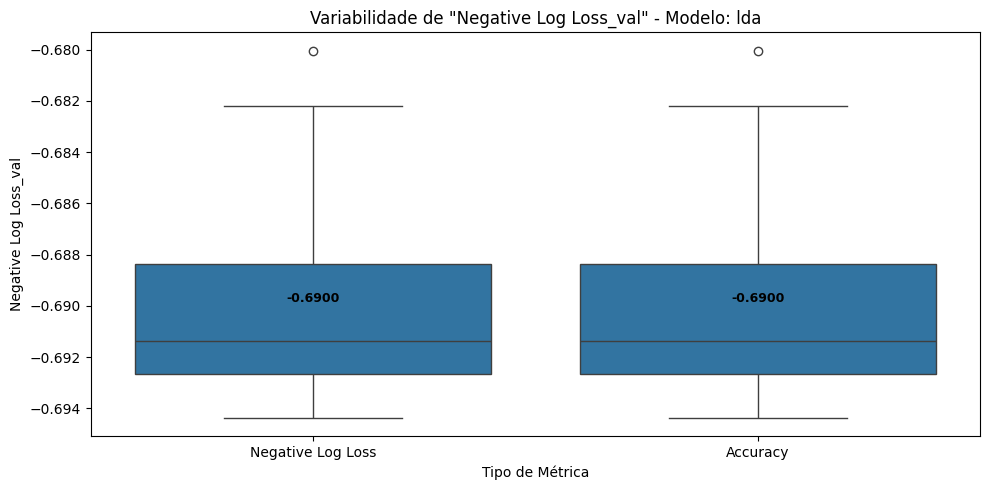

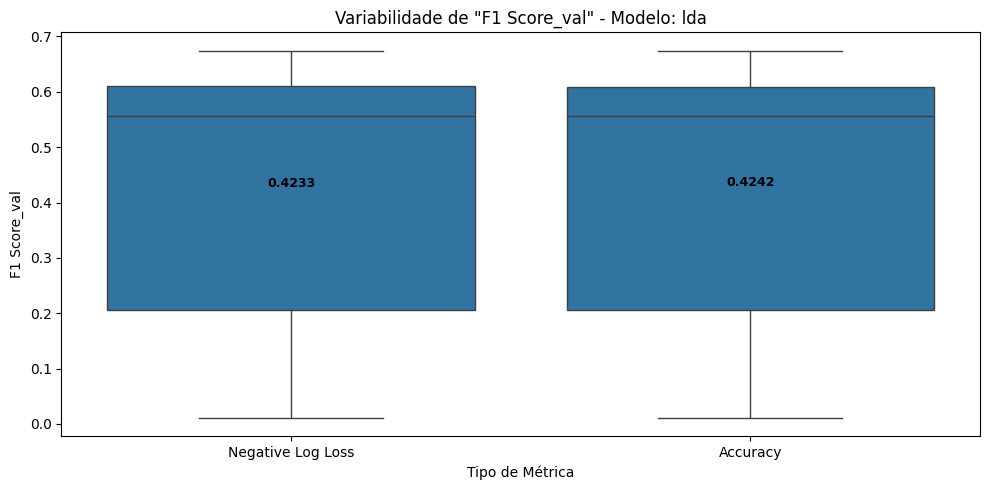

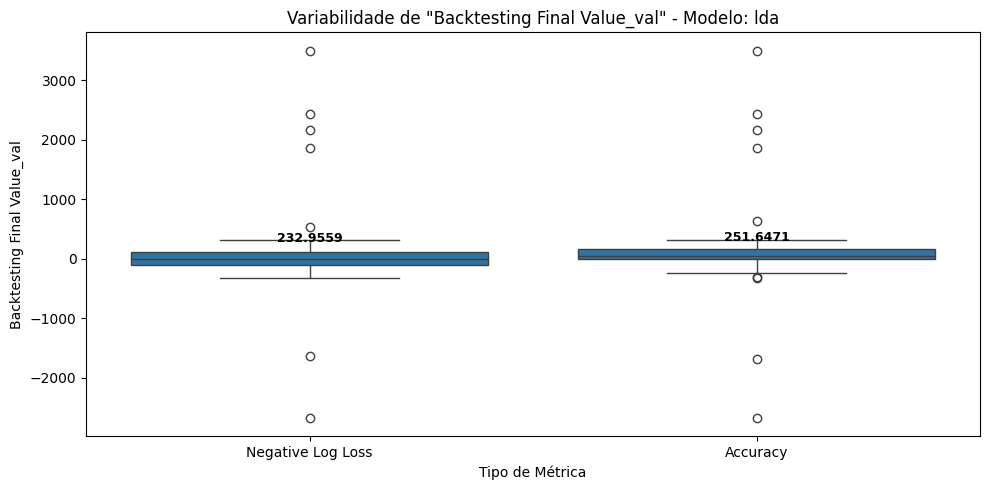

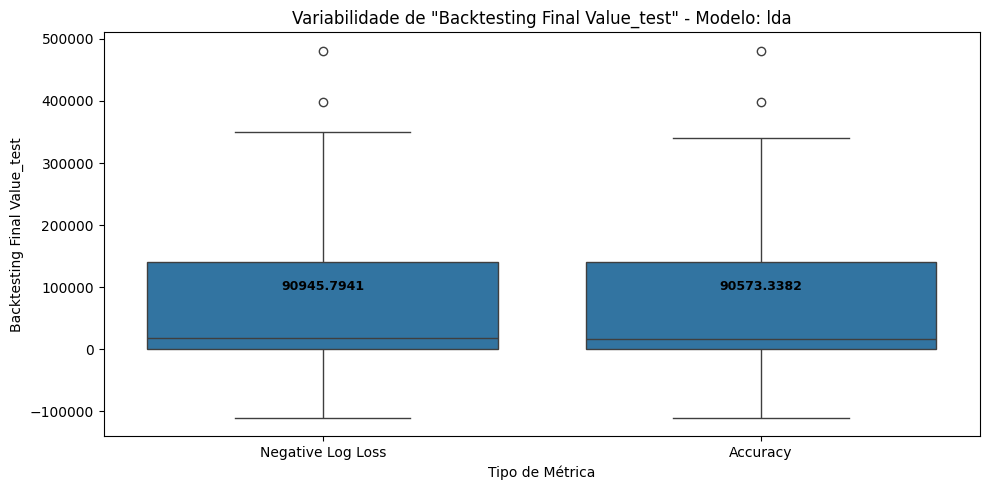

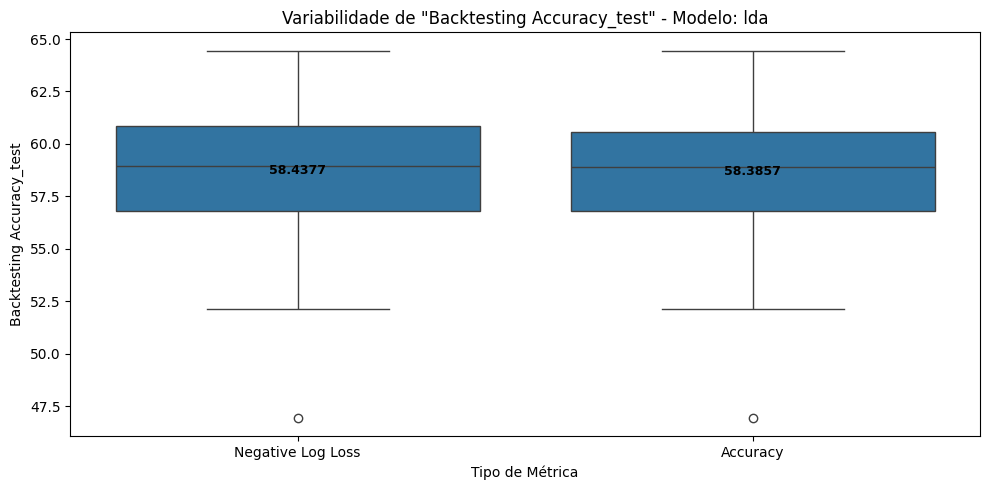

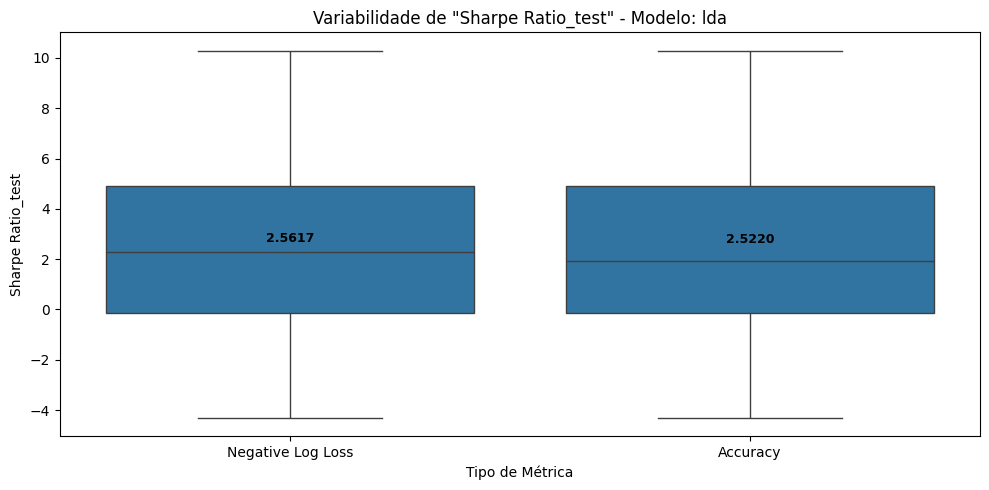

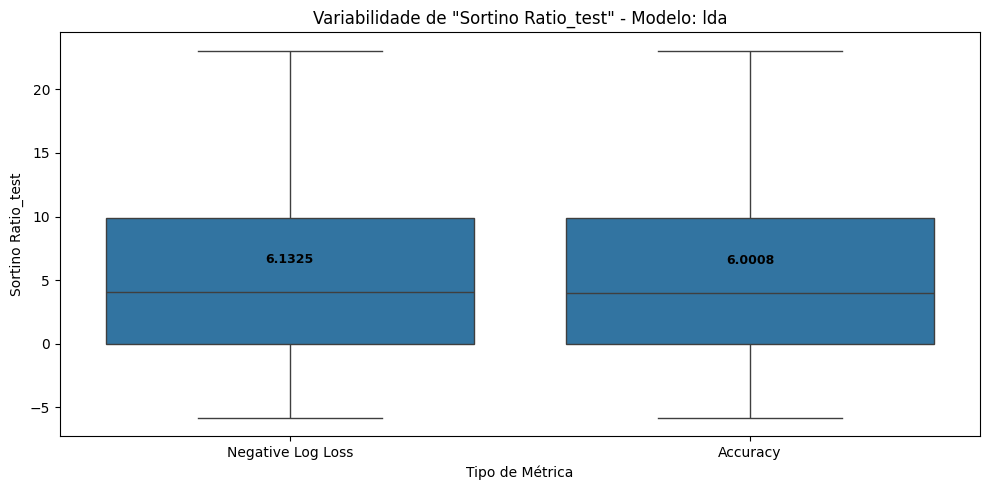

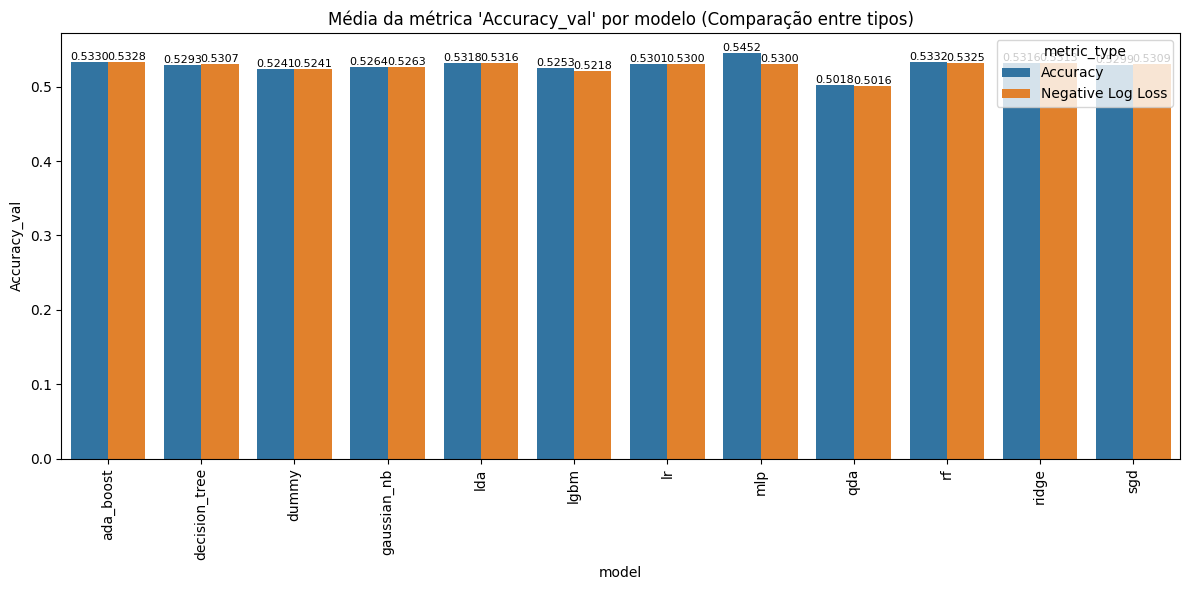

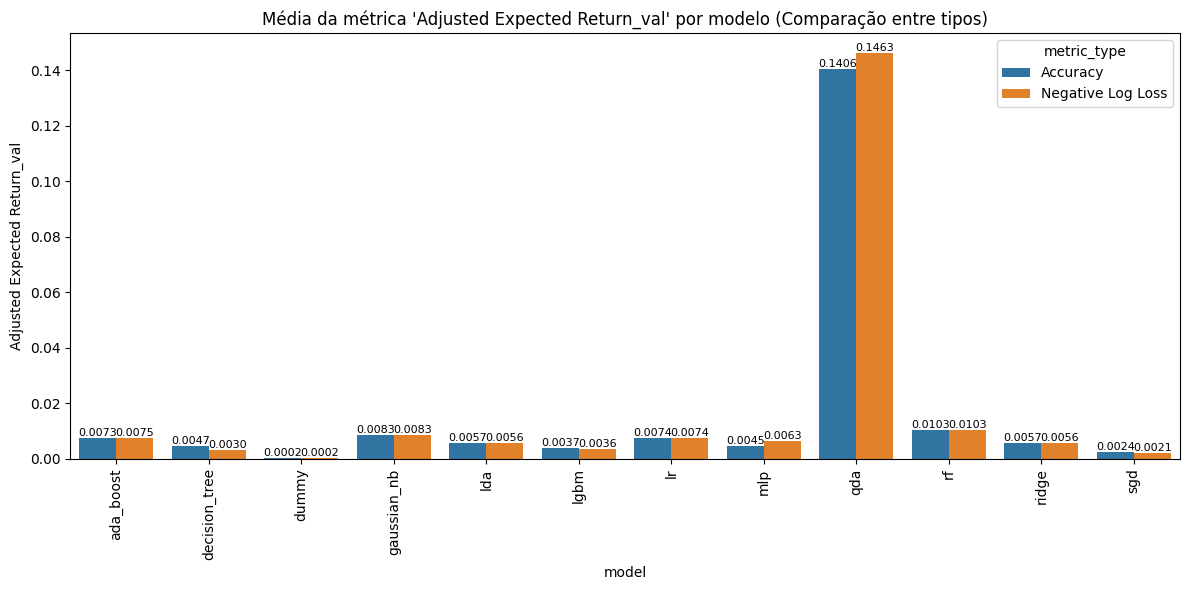

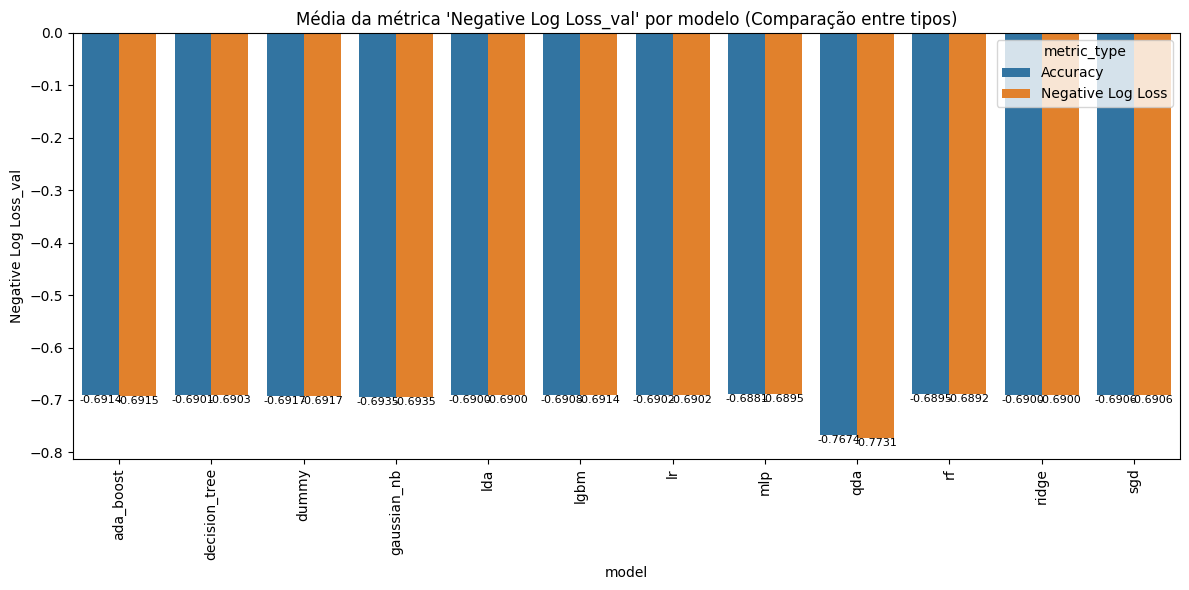

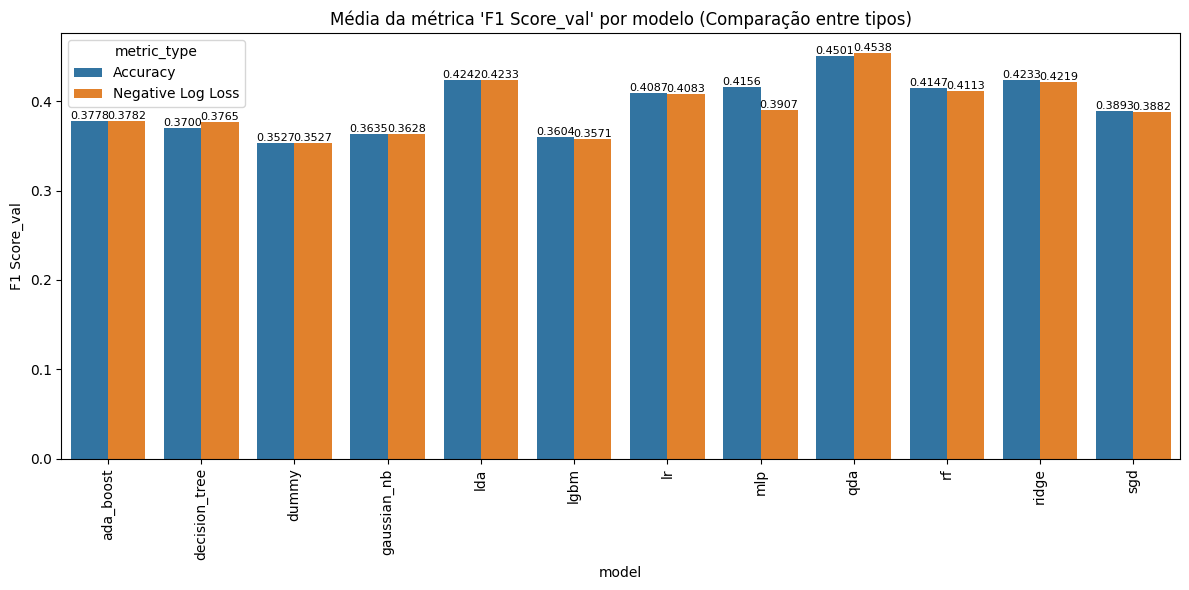

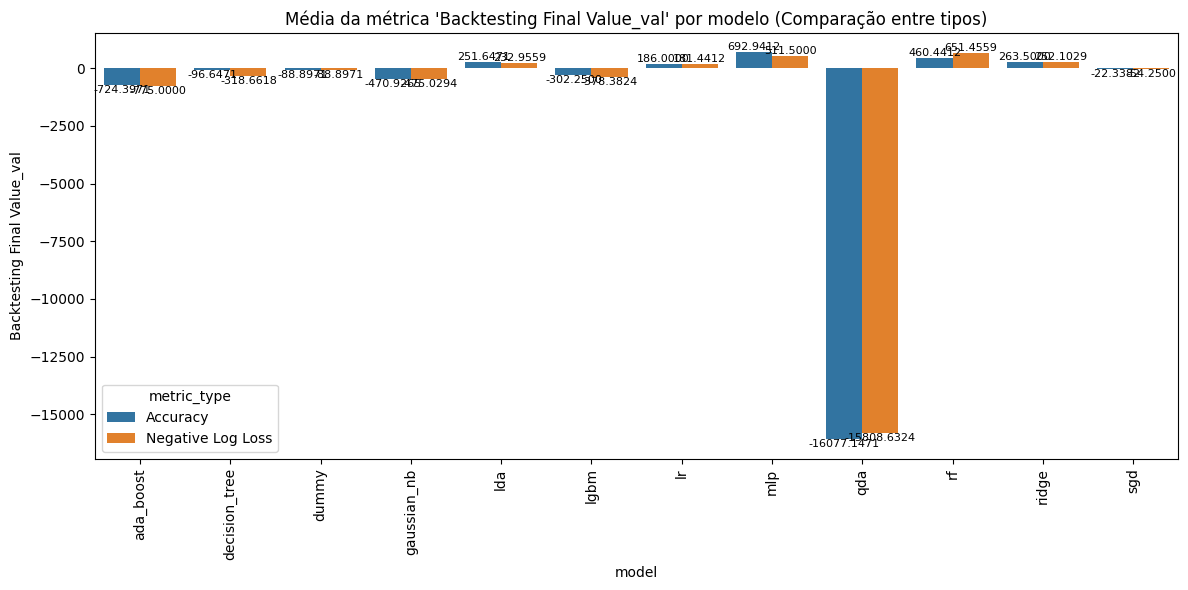

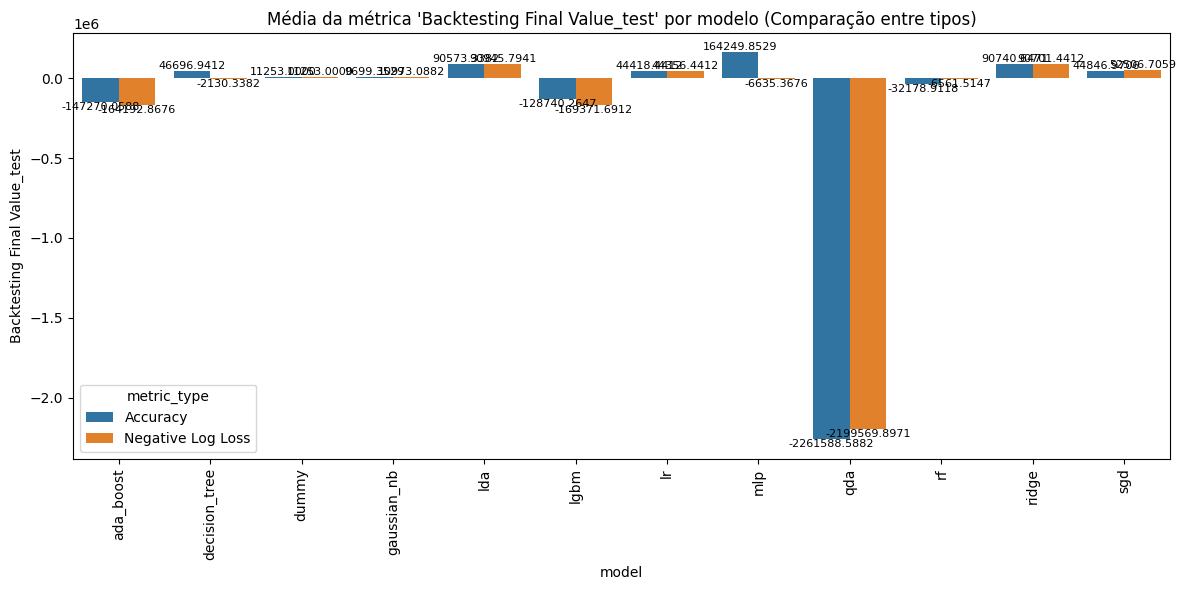

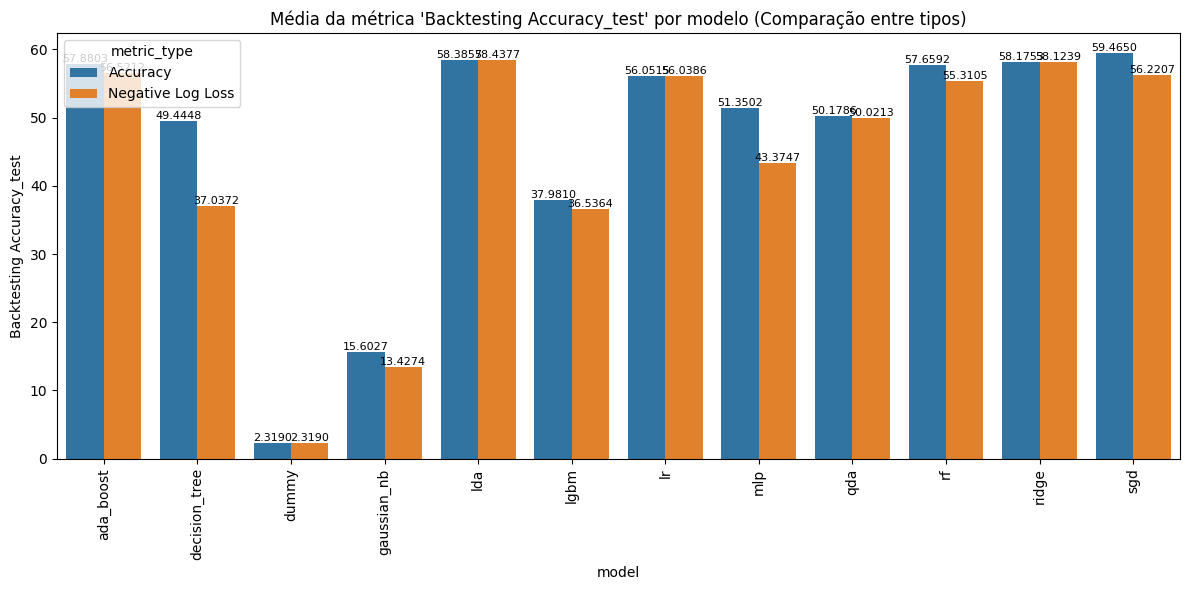

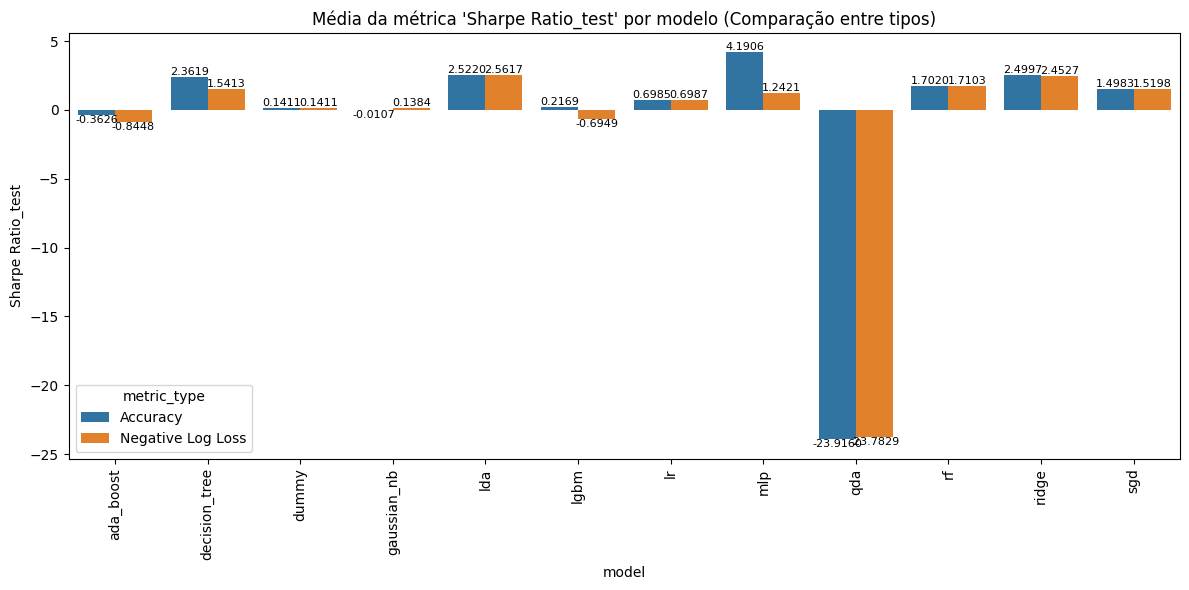

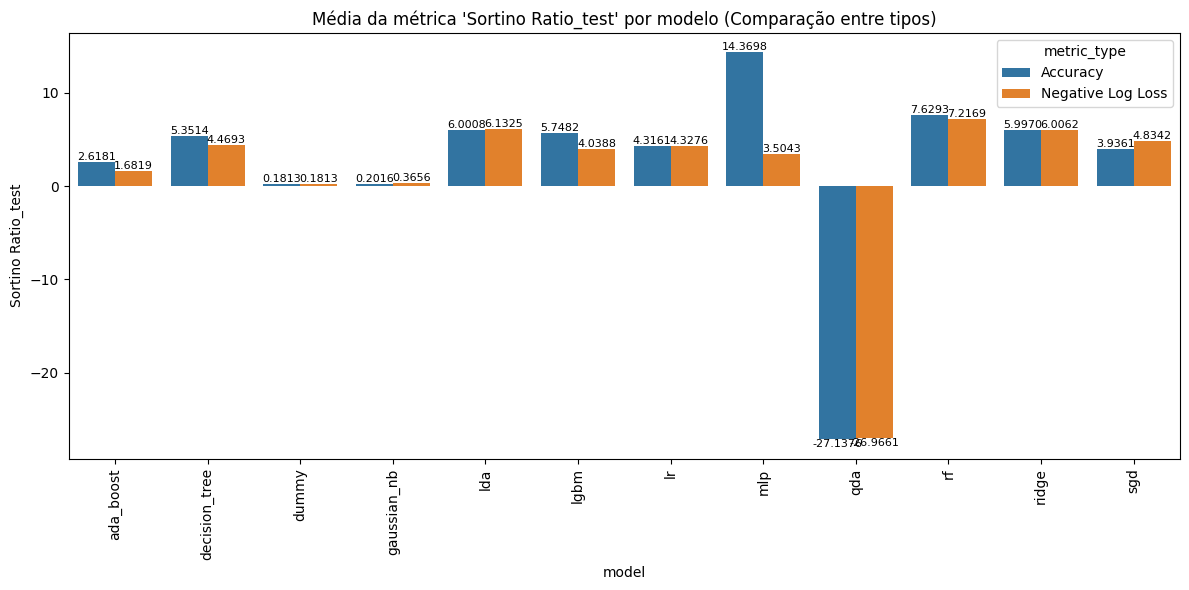

In [81]:
plot_combined_model_average_metrics("lda", combined_df)
plot_combined_model_metric_variability("lda", combined_df)
plot_combined_average_metrics_all_models(combined_df)


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
results = []

# Group by asset
for asset_type, group in df.groupby("type"):
    # Drop rows with NaN in relevant columns to avoid errors
    group = group.dropna(subset=["Accuracy", "Adjusted Expected Return", "Backtesting Final Value"])

    # Calculate correlations
    corr_accuracy = group["Accuracy"].corr(group["Backtesting Final Value"])
    corr_adj_return = group["Adjusted Expected Return"].corr(group["Backtesting Final Value"])
    
    # Determine which one is more correlated
    more_correlated = "Adjusted Expected Return" if abs(corr_adj_return) > abs(corr_accuracy) else "Accuracy"

    results.append({
        "asset_type": asset_type,
        "corr_accuracy": corr_accuracy,
        "corr_adj_expected_return": corr_adj_return,
        "more_correlated": more_correlated
    })

# Create a summary DataFrame
correlation_df = pd.DataFrame(results)

# Show results
print(correlation_df)


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

results = []

for asset_type, group in df.groupby("type"):
    group = group.dropna(subset=["Accuracy", "Adjusted Expected Return", "Negative Log Loss", "Backtesting Final Value"])

    if len(group) >= 2:
        corr_acc, p_acc = pearsonr(group["Accuracy"], group["Backtesting Final Value"])
        corr_adj, p_adj = pearsonr(group["Adjusted Expected Return"], group["Backtesting Final Value"])
        corr_f1, p_f1 = pearsonr(group["Negative Log Loss"], group["Backtesting Final Value"])
    else:
        corr_acc, p_acc, corr_adj, p_adj, corr_f1, p_f1 = [np.nan] * 6

    # Which one is most correlated
    max_corr = max([(abs(corr_acc), "Accuracy"),
                    (abs(corr_adj), "Adjusted Expected Return"),
                    (abs(corr_f1), "Negative Log Loss")], key=lambda x: x[0])[1]

    results.append({
        "asset_type": asset_type,
        "corr_accuracy": corr_acc,
        "pval_accuracy": p_acc,
        "corr_adj_expected_return": corr_adj,
        "pval_adj": p_adj,
        "corr_f1": corr_f1,
        "pval_f1": p_f1,
        "most_correlated": max_corr
    })

correlation_df = pd.DataFrame(results)


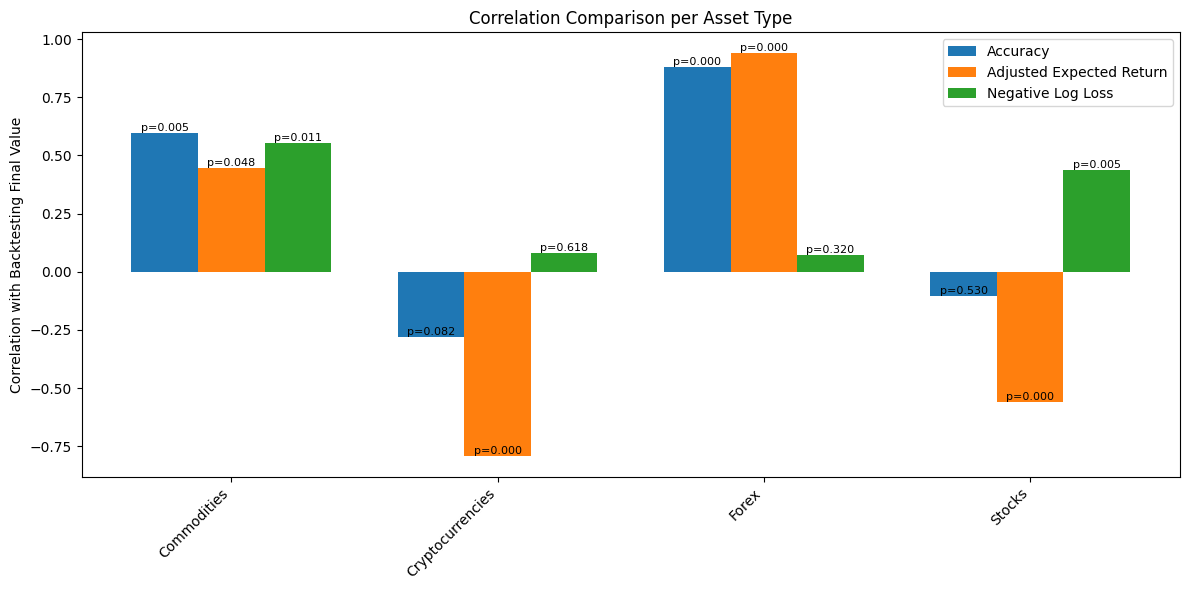

In [ ]:
x = np.arange(len(correlation_df))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(x - width, correlation_df["corr_accuracy"], width, label='Accuracy')
bar2 = ax.bar(x, correlation_df["corr_adj_expected_return"], width, label='Adjusted Expected Return')
bar3 = ax.bar(x + width, correlation_df["corr_f1"], width, label='Negative Log Loss')

# Add labels and formatting
ax.set_ylabel('Correlation with Backtesting Final Value')
ax.set_title('Correlation Comparison per Asset Type')
ax.set_xticks(x)
ax.set_xticklabels(correlation_df["asset_type"], rotation=45, ha='right')
ax.legend()

# Annotate bars with p-values
for i, (b1, b2, b3) in enumerate(zip(bar1, bar2, bar3)):
    ax.text(b1.get_x() + b1.get_width()/2, b1.get_height(), f"p={correlation_df['pval_accuracy'][i]:.3f}", 
            ha='center', va='bottom', fontsize=8, rotation=0)
    ax.text(b2.get_x() + b2.get_width()/2, b2.get_height(), f"p={correlation_df['pval_adj'][i]:.3f}", 
            ha='center', va='bottom', fontsize=8, rotation=0)
    ax.text(b3.get_x() + b3.get_width()/2, b3.get_height(), f"p={correlation_df['pval_f1'][i]:.3f}", 
            ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


In [59]:
def get_ranking(df):
    # Metrics of interest
    metrics = ["Accuracy", "Adjusted Expected Return", "Negative Log Loss", "F1 Score",  "Backtesting Final Value", "Backtesting Accuracy", "Sharpe Ratio", "Sortino Ratio",]
    # Group by model and compute mean
    grouped = df.groupby("model")[metrics].mean(numeric_only=True)

    # Rank each metric (lower is better for Negative Log Loss, higher is better for others)
    ranking = pd.DataFrame(index=grouped.index)
    ranking['Negative Log Loss Rank'] = grouped['Negative Log Loss'].rank(ascending=True, method='min')
    ranking['Accuracy Rank'] = grouped['Accuracy'].rank(ascending=False, method='min')
    ranking['Adjusted Expected Return Rank'] = grouped['Adjusted Expected Return'].rank(ascending=False, method='min')
    ranking['Backtesting Final Value Rank'] = grouped['Backtesting Final Value'].rank(ascending=False, method='min')
    ranking['F1 Score Rank'] = grouped['F1 Score'].rank(ascending=False, method='min')
    ranking['Backtesting Accuracy Rank'] = grouped['Backtesting Accuracy'].rank(ascending=False, method='min')
    ranking['Sharpe Ratio Rank'] = grouped['Sharpe Ratio'].rank(ascending=False, method='min')
    ranking['Sortino Ratio Rank'] = grouped['Sortino Ratio'].rank(ascending=False, method='min')

    # Optional: Calculate an overall average rank
    ranking['Average Rank'] = ranking.mean(axis=1)

    # Reset index to make 'model' a column
    ranking.reset_index(inplace=True)
    return ranking
# Show result


In [60]:
get_ranking(df_neg_log_loss)

KeyError: "Columns not found: 'Sortino Ratio', 'Negative Log Loss', 'Accuracy', 'Sharpe Ratio', 'Backtesting Final Value', 'Backtesting Accuracy', 'Adjusted Expected Return', 'F1 Score'"

In [58]:
get_ranking(df_accuracy)

model  Negative Log Loss Rank  Accuracy Rank  \
0      ada_boost                     5.0            5.0   
1  decision_tree                     6.0            4.0   
2          dummy                     3.0            8.0   
3    gaussian_nb                     4.0            6.0   
4            lda                     9.0            1.0   
5           lgbm                     2.0            7.0   
6            qda                     1.0            9.0   
7          ridge                     8.0            2.0   
8            sgd                     7.0            3.0   

   Adjusted Expected Return Rank  Backtesting Final Value Rank  F1 Score Rank  \
0                            6.0                           7.0            6.0   
1                            5.0                           6.0            7.0   
2                            9.0                           5.0            9.0   
3                            8.0                           3.0            4.0   
4                            3.0                           2.0            1.0   
5                            4.0                           8.0            8.0   
6                            1.0                           9.0            5.0   
7                            2.0                           1.0            2.0   
8                            7.0                           4.0            3.0   

   Backtesting Accuracy Rank  Sharpe Ratio Rank  Sortino Ratio Rank  \
0                        1.0                4.0                 5.0   
1                        7.0                1.0                 2.0   
2                        9.0                6.0                 7.0   
3                        8.0                5.0                 8.0   
4                        3.0                3.0                 4.0   
5                        6.0                7.0                 1.0   
6                        5.0                9.0                 9.0   
7                        2.0                2.0                 3.0   
8                        4.0                8.0                 6.0   

   Average Rank  
0         4.875  
1         4.750  
2         7.000  
3         5.750  
4         3.250  
5         5.375  
6         6.000  
7         2.750  
8         5.250

In [41]:
grouped['Negative Log Loss'].sort_values()

model
mlp              0.683092
ridge            0.683300
lda              0.683603
ada_boost        0.684908
gaussian_nb      0.685099
sgd              0.685147
decision_tree    0.685695
dummy            0.686217
lgbm             0.686311
qda              0.687876
Name: Negative Log Loss, dtype: float64

In [20]:
from model_pipeline.pipeline.pipeline import ModelPipeline

asset = ["GBPUSD"]
model = 'lgbm'
pipeline = ModelPipeline(assets=asset)

# Load data
data = pipeline.load_data(asset=asset[0])
X_train_scaled, X_test_scaled, y_train, y_test = pipeline.prepare_data(data)


In [21]:
model = pipeline.get_model(asset=asset[0], model_name=model)

In [22]:
model

CalibratedClassifierCV(cv=5,
                       estimator=LGBMClassifier(max_depth=3, n_estimators=50))

In [23]:
from model_pipeline.evaluation.backtesting import BacktestingSimulator

# Create a backtesting simulator
y_pred = model.predict(X_test_scaled)
y_prop = model.predict_proba(X_test_scaled)[:, 1]
backtester = BacktestingSimulator()
r = backtester.simulate(y_true=y_test, y_pred=y_pred, y_prob=y_prop)
r

{'accuracy': 0,
 'projected_outcome': 0.0,
 'df_trade': Empty DataFrame
 Columns: [Prediction, Real, pred_class, prediction_certainty, predict_result, kelly, entered_trade, returned_amount]
 Index: [],
 'operation_percent': 0.0,
 'returns': 0,
 'ROI': 0,
 'sharpe_ratio': 0,
 'sortino_ratio': 0,
 'total_trades': 0,
 'winning_trades': 0,
 'losing_trades': 0,
 'total_invested': 0,
 'max_balance': 1000,
 'min_balance': 1000,
 'final_balance': 1000,
 'kelly_value': 0,
 'avg_return_per_trade': 0.0,
 'return_std': 0,
 'downside_std': 0,
 'expected return': 0,
 'adjusted expected return': 0}

In [24]:
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

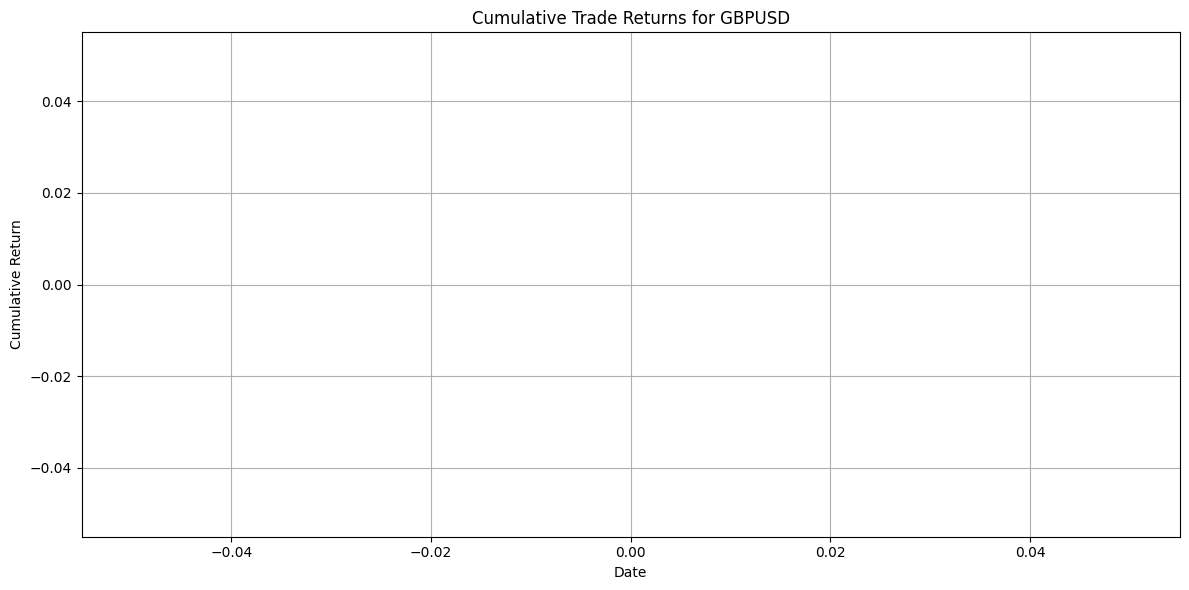

IndexError: single positional indexer is out-of-bounds

In [25]:
import matplotlib.pyplot as plt

def plot_df_trade_returns(result: dict, title: str = "Cumulative Trade Returns Over Time"):
    """
    Plot the cumulative returns from the df_trade DataFrame over time using matplotlib.

    Args:
        df_trade (pd.DataFrame): DataFrame returned by simulate or test_model.
        title (str): Plot title.
    """
    df_trade = result['df_trade']
    
    df_trade.sort_index(inplace=True)
    # Calculate cumulative returns
    df_trade['cumulative_return'] = df_trade['returned_amount'].cumsum()

    # Plot using matplotlib
    plt.figure(figsize=(12, 6))
    plt.plot(df_trade.index, df_trade['cumulative_return'], marker='o', linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Final cumulative return: {df_trade['cumulative_return'].iloc[-1]:.2f}")
    

plot_df_trade_returns(r, title=f"Cumulative Trade Returns for {asset[0]}")


In [ ]:
import os
import pandas as pd
from datetime import datetime

# Path to the candles folder
folder_path = '../candles'

# List to store start and end dates
date_ranges = []

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('_M1.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read only the first and last row of the CSV
        # Assuming the datetime column is the first column (index 0)
        try:
            file = pd.read_csv(file_path)
        
        except:
            continue
        # Convert to datetime (adjust the column name if different)
        start_date = pd.to_datetime(file['from'].iloc[0], unit='s')
        end_date = pd.to_datetime(file['from'].iloc[-1], unit='s')
        
        # Store the results
        date_ranges.append({
            'file': filename,
            'start_date': start_date,
            'end_date': end_date,
            'length': len(file)
        })
        # print({
        #     'file': filename,
        #     'start_date': start_date,
        #     'end_date': end_date
        # })

# Print results
for date_range in date_ranges:
    print(f"File: {date_range['file']}")
    print(f"Start date: {date_range['start_date']}")
    print(f"End date: {date_range['end_date']}")
    print(f"length: {date_range['length']}")
    print("-" * 50)

File: XETHUSD_M1.csv
Start date: 2023-03-19 00:00:00
End date: 2025-03-17 23:59:00
length: 1074480
--------------------------------------------------
File: AAPL_M1.csv
Start date: 2023-03-27 08:00:00
End date: 2025-03-25 23:59:00
length: 376540
--------------------------------------------------
File: AMZN_M1.csv
Start date: 2023-03-27 08:00:00
End date: 2025-03-25 23:59:00
length: 372786
--------------------------------------------------
File: XXRPUSD_M1.csv
Start date: 2023-03-19 00:00:00
End date: 2025-03-17 23:59:00
length: 1043200
--------------------------------------------------
File: GBPCHF_M1.csv
Start date: 2023-03-19 18:21:00
End date: 2025-03-17 23:59:00
length: 748638
--------------------------------------------------
File: XPTUSD_M1.csv
Start date: 2024-02-01 15:43:00
End date: 2024-02-01 16:14:00
length: 64
--------------------------------------------------
File: AUDJPY_M1.csv
Start date: 2023-03-19 00:14:00
End date: 2025-03-17 23:59:00
length: 768780
-------------------

% LaTeX for Table~\ref{tab:stat_test_ranks}
\begin{table}
\caption{Average test-set rank per model for statistical metrics.}
\label{tab:stat_test_ranks}
\begin{tabular}{lrrrr}
\toprule
Model & Negative Log Loss & Accuracy & F1 Score & AUC \\
\midrule
ada_boost & 6.84 & 6.48 & 5.60 & 4.92 \\
decision_tree & 5.52 & 6.66 & 7.60 & 6.36 \\
dummy & 8.64 & 9.48 & 6.50 & 10.64 \\
gaussian_nb & 7.44 & 8.44 & 6.76 & 8.08 \\
lda & 5.48 & 4.72 & 6.22 & 4.88 \\
lgbm & 7.16 & 8.22 & 7.50 & 7.00 \\
lr & 4.88 & 3.86 & 6.20 & 4.08 \\
mlp & 5.72 & 5.32 & 4.48 & 5.72 \\
qda & 8.84 & 9.06 & 6.14 & 9.08 \\
rf & 6.08 & 6.66 & 7.82 & 6.56 \\
ridge & 5.56 & 4.34 & 6.10 & 4.76 \\
sgd & 5.84 & 4.76 & 7.08 & 5.92 \\
\bottomrule
\end{tabular}
\end{table}


% LaTeX for Table~\ref{tab:util_test_ranks}
\begin{table}
\caption{Average test-set rank per model for utility metrics.}
\label{tab:util_test_ranks}
\begin{tabular}{lrrrr}
\toprule
Model & Backtesting Final Value & Sortino Ratio & Sharpe Ratio & Return over Ris

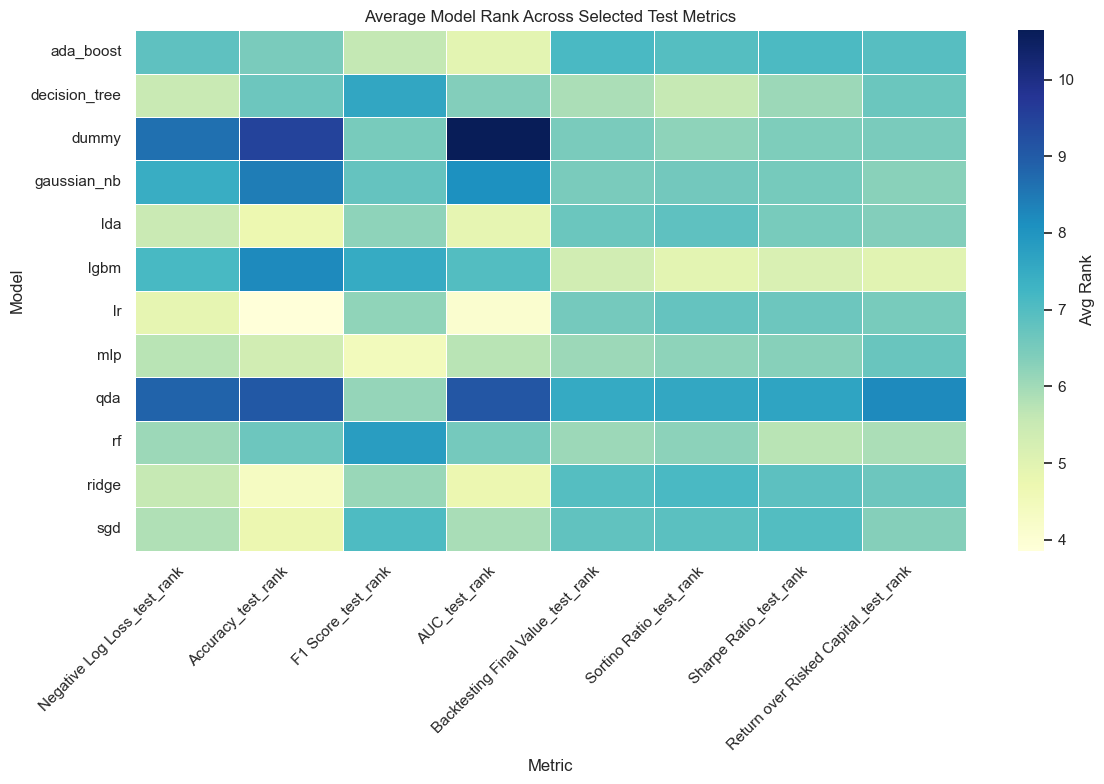

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the ranked data
df = ranked_df


# Define metric groups (test only)
statistical = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility     = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital']

# Get relevant test rank columns
stat_cols = [f"{m}_test_rank" for m in statistical]
util_cols = [f"{m}_test_rank" for m in utility]

# Compute average rank per model per metric
stat_table = df.groupby('model')[stat_cols].mean().round(2).reset_index()
util_table = df.groupby('model')[util_cols].mean().round(2).reset_index()

# Clean column names for display in LaTeX
stat_table.columns = ['Model'] + statistical
util_table.columns = ['Model'] + utility

# Output LaTeX tables
print("% LaTeX for Table~\\ref{tab:stat_test_ranks}")
print(stat_table.to_latex(index=False, float_format="%.2f",
      caption="Average test-set rank per model for statistical metrics.",
      label="tab:stat_test_ranks"))

print("\n% LaTeX for Table~\\ref{tab:util_test_ranks}")
print(util_table.to_latex(index=False, float_format="%.2f",
      caption="Average test-set rank per model for utility metrics.",
      label="tab:util_test_ranks"))

# Generate heatmap across all 8 test metrics
all_test_cols = stat_cols + util_cols
avg_all = df.groupby('model')[all_test_cols].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(avg_all, cmap="YlGnBu", cbar_kws={'label': 'Avg Rank'}, linewidths=0.5)
plt.title('Average Model Rank Across Selected Test Metrics')
plt.xlabel('Metric')
plt.ylabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('average_model_ranks_heatmap.png')
plt.show()


In [50]:
# Statistical metrics heatmap
stat_heat = avg_ranks.set_index('model')[stat_cols]
stat_heat.columns = stat_metrics
plt.figure(figsize=(6, 8))
sns.heatmap(stat_heat, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Avg Rank'})
plt.title('Model Ranking on Statistical Metrics')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('stat_rank_heatmap.png')
plt.close()

# Utility metrics heatmap
util_heat = avg_ranks.set_index('model')[util_cols]
util_heat.columns = util_metrics
plt.figure(figsize=(6, 8))
sns.heatmap(util_heat, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Avg Rank'})
plt.title('Model Ranking on Utility Metrics')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('util_rank_heatmap.png')
plt.close()

In [120]:
from itertools import combinations
# Function to compute delta table
def compute_stat_vs_utility_deltas(ranked_df, stat_metrics, utility_metrics, model_col='model', top_n=3):
    results = []

    for stat_metric in stat_metrics:
        stat_rank_col = f"{stat_metric}_test_rank"

        # Identify top N models in this statistical metric
        top_models = ranked_df.nsmallest(top_n, stat_rank_col)[model_col].drop_duplicates().tolist()

        # Compare all model pairs in the top-N set
        for model_a, model_b in combinations(top_models, 2):
            if model_a == model_b:
                continue
            row = {
                'Metric Improved': stat_metric,
                'From Model A': model_a,
                'To Model B': model_b
            }

            # Get their stat rank
            stat_a = ranked_df.loc[ranked_df[model_col] == model_a, stat_rank_col].values[0]
            stat_b = ranked_df.loc[ranked_df[model_col] == model_b, stat_rank_col].values[0]
            delta_stat = stat_a - stat_b

            for utility_metric in utility_metrics:
                utility_rank_col = f"{utility_metric}_test_rank"
                util_a = ranked_df.loc[ranked_df[model_col] == model_a, utility_rank_col].values[0]
                util_b = ranked_df.loc[ranked_df[model_col] == model_b, utility_rank_col].values[0]
                delta_util = util_a - util_b
                aligned = (delta_stat > 0 and delta_util > 0) or (delta_stat < 0 and delta_util < 0)

                row.update({
                    'ΔStat Rank': round(delta_stat, 2),
                    f'Δ{utility_metric}': round(delta_util, 2),
                    f'Aligned with {utility_metric}?': aligned
                })

            results.append(row)

    return pd.DataFrame(results)

# Define metric groups
stat_metrics = ['Negative Log Loss', 'Accuracy']
utility_metrics = ['Backtesting Final Value', 'Sharpe Ratio',]

# Generate the delta table
delta_table = compute_stat_vs_utility_deltas(ranked_df, stat_metrics, utility_metrics, top_n=20)

# Show first 10 rows
delta_table#.head(10)

Metric Improved From Model A     To Model B  ΔStat Rank  \
0   Negative Log Loss    ada_boost  decision_tree         1.0   
1   Negative Log Loss    ada_boost    gaussian_nb         3.0   
2   Negative Log Loss    ada_boost            lda         6.0   
3   Negative Log Loss    ada_boost           lgbm         8.0   
4   Negative Log Loss    ada_boost             lr         9.0   
..                ...          ...            ...         ...   
59           Accuracy          mlp          ridge         2.0   
60           Accuracy          mlp            sgd         7.0   
61           Accuracy           rf          ridge        -3.0   
62           Accuracy           rf            sgd         2.0   
63           Accuracy        ridge            sgd         5.0   

    ΔBacktesting Final Value  Aligned with Backtesting Final Value?  \
0                       -4.0                                  False   
1                        5.0                                   True   
2                       -1.5                                  False   
3                        1.0                                   True   
4                       -3.0                                  False   
..                       ...                                    ...   
59                      -6.5                                  False   
60                      -3.0                                  False   
61                      -4.5                                   True   
62                      -1.0                                  False   
63                       3.5                                   True   

    ΔSharpe Ratio  Aligned with Sharpe Ratio?  
0            -3.0                       False  
1             4.0                        True  
2            -4.5                       False  
3             1.0                        True  
4            -2.0                       False  
..            ...                         ...  
59           -8.5                       False  
60           -5.0                       False  
61           -6.5                        True  
62           -3.0                       False  
63            3.5                        True  

[64 rows x 8 columns]

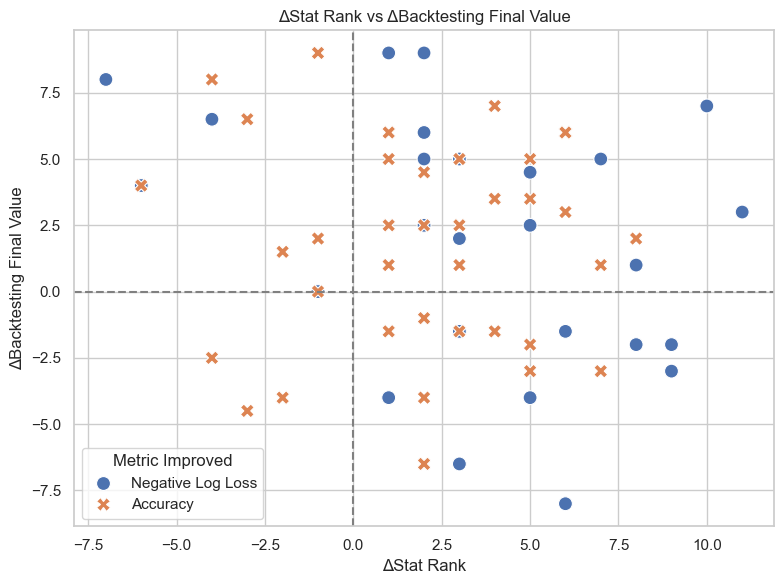

In [135]:

def scatter_delta_plot(df, delta_stat_col='ΔStat Rank', delta_util_col='ΔBacktesting Final Value'):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=delta_stat_col, y=delta_util_col, hue='Metric Improved', style='Metric Improved', s=100)

    # Add center lines
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    plt.title(f"{delta_stat_col} vs ΔBacktesting Final Value")
    plt.xlabel(delta_stat_col)
    plt.ylabel('ΔBacktesting Final Value')
    plt.tight_layout()
    plt.show()

scatter_delta_plot(delta_table, delta_stat_col='ΔStat Rank', delta_util_col='ΔBacktesting Final Value')

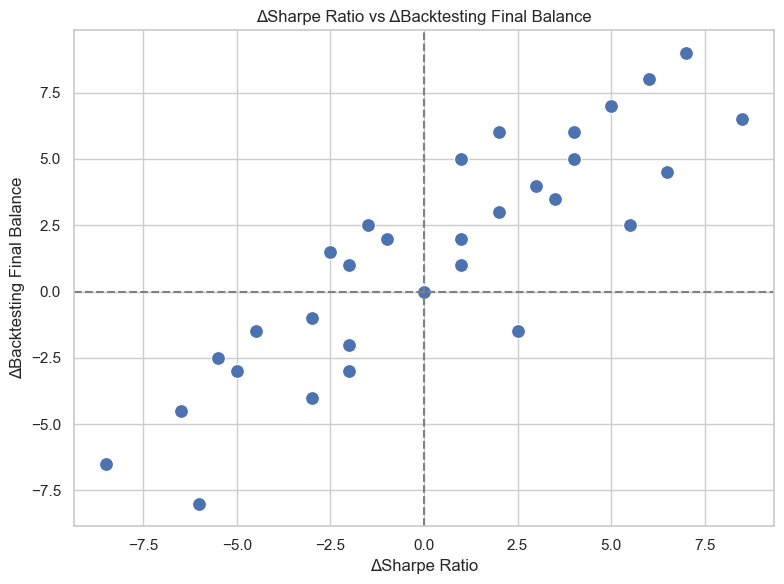

In [136]:
def scatter_delta_plot(df, delta_stat_col='ΔSharpe Ratio', delta_util_col='ΔBacktesting Final Value'):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=delta_stat_col, y=delta_util_col, s=100)

    # Add center lines
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    plt.title(f"{delta_stat_col} vs ΔBacktesting Final Balance")
    plt.tight_layout()
    plt.ylabel('ΔBacktesting Final Balance')
    plt.show()

scatter_delta_plot(delta_table, delta_stat_col='ΔSharpe Ratio', delta_util_col='ΔBacktesting Final Value')